In [1]:
#%run 'word2vec_data.ipynb'
import cPickle as pickle
%pylab inline

import scipy
import numpy as np
import pandas as pd
#import plotly.plotly as py
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from gensim import models


import math
import codecs
import re
import string
from time import time


## Sklearn
from sklearn import svm, datasets
import sklearn

from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, roc_auc_score, accuracy_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, precision_score
from sklearn.preprocessing import StandardScaler, label_binarize, Imputer, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier, RandomTreesEmbedding
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn import datasets, feature_selection, cluster, feature_extraction
from sklearn import neighbors, decomposition, metrics
from sklearn import decomposition, feature_selection, model_selection
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


from sklearn.pipeline import Pipeline, make_pipeline
from scipy import interp

#############################
### Matplotlib
import matplotlib.pyplot as plt # module for plotting 
from matplotlib import interactive, font_manager
from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

#############################
### other stuff
from IPython import display

import os
#import ipyparallel as ipp
import warnings
warnings.filterwarnings('ignore')

# This is here to avoid all the Matplotlib warnings due to current bugs 
# - not a good idea to keep around
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline  

print ("Required Libraries loaded.")

Populating the interactive namespace from numpy and matplotlib
Required Libraries loaded.


In [2]:
#!pip install --upgrade version_information
#%reload_ext version_information
%load_ext version_information 
%version_information scipy, numpy, sklearn, pandas, scipy, nltk, gensim, matplotlib, os, cpickle

Software versions
Python 2.7.12 64bit [MSC v.1500 64 bit (AMD64)]
IPython 5.1.0
OS Windows 7 6.1.7601 SP1
scipy 0.18.1
numpy 1.11.2
sklearn 0.18.1
pandas 0.19.1
scipy 0.18.1
nltk 3.2.1
gensim 0.12.4
matplotlib 1.5.3
os The 'os' distribution was not found and is required by the application
cpickle The 'cpickle' distribution was not found and is required by the application
Tue Jan 24 18:15:09 2017 GMT Standard Time

In [3]:
inhibitor  = pd.read_csv("C:\EPC_Data\TREC_BROKEN\No_Mh_Tag/statins_no_mh.csv", sep=",", index_col = "PMID")

In [4]:
folder = "C:\Users\CR107\Dropbox\PhD\Experiments\TREC_2004\data\word2vec"
filepath = os.path.join(folder, "statins_chi2_features_10minwords_15context")
model = models.Word2Vec.load(filepath)
print (model["clinical"][:10])
print ("\nMatrix of word vectors is size : ", model.syn0.shape)

[ 0.0481628   0.00542244 -0.06516281 -0.01437724 -0.01788619  0.03306651
 -0.08533742 -0.00674916 -0.04490625 -0.01492935]
('\nMatrix of word vectors is size : ', (4579L, 467L))


In [5]:
#Create feature vectors from the averages of word vectors

def makeFeatureVec(words, model):
    """
    words - list of words (i.e. article) to be used as input for the creation of word vectors
    model - model to use for the creation of the vectors
    
    makeFeatureVec: Function to average all of the word vectors in a given paragraph
    returns: a numpy array of floats that are the average of the constituent word vectors for each word
    """
    num_features = model.syn0.shape[1]
    featureVec = np.zeros((num_features,),dtype="float32")
    nwords = 0.
    # 
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.index2word)
    #
    # Loop over each word in the article and, if it is in the model's
    # vocaublary, add its feature vector to the total
    for word in words:
        if word in index2word_set: 
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

def getAvgFeatureVecs(articles, model):
    """
    articles - list of articles for which the creation of word vectors needs to be done for each
    model - model to use for the creation of the vectors
    
    getAvgFeatureVecs: Given a set of articles (each one a list of words), calculate 
    the average feature vector for each one and return a 2D numpy array 
    returns: a 2D numpy array that contains the average of the constituent word vectors for each article
    """
    num_features = model.syn0.shape[1]
    articleFeatureVecs = np.zeros((len(articles),num_features),dtype="float32")
    counter = 0.
    
    # Loop through the articles
    for article in articles:
        #
        # Print a status message every 1000th review
        if counter%500. == 0.:
            print ("Article %d of %d" % (counter, len(articles)))
        # 
        # Call the function (defined above) that makes average feature vectors
        articleFeatureVecs[counter] = makeFeatureVec(article, model)
        #
        # Increment the counter
        counter = counter + 1.
    return articleFeatureVecs

In [6]:
# Import articles for string cleaning

def clean_text(text, stem_words = False, remove_stopwords = False):
    ###clean
    texts = re.sub("[^a-zA-Z]",    #pattern to match
              " ",              #replace other with this
              str(text))                 #text to apply to
         
    #print "Text recived: ", texts 
    clean_corpus = texts.lower().split()
    #print "corpus: ", clean_corpus
    if stem_words:
        # Porter stemmer
        porter = nltk.PorterStemmer()
        # Snowball stemmer
        snowball = nltk.SnowballStemmer('english')
        # Lancaster stemmer
        lancaster = nltk.LancasterStemmer()
        # General stemming Lambda function to stem tokens
        clean_corpus = lambda tokens: [porter.stem(w) for w in corpus]
    if remove_stopwords:   # Optionally remove stop words
        stops = set(stopwords.words("english"))
        clean_corpus = [w for w in clean_corpus if not w in stops]
        #print "Clean_corpus: ", clean_corpus
    
    return (clean_corpus)

In [7]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. We remove stopwords.

print ("Creating average feature vecs for articles")
cleaned_articles = []
for article in inhibitor.TIABSMh:
    cleaned_articles.append(clean_text(article, stem_words=False, remove_stopwords=True ))

averageWordVecs = getAvgFeatureVecs(cleaned_articles, model)

Creating average feature vecs for articles
Article 0 of 3402
Article 500 of 3402
Article 1000 of 3402
Article 1500 of 3402
Article 2000 of 3402
Article 2500 of 3402
Article 3000 of 3402


In [8]:
RANDOM_STATE = 55
TEST_SIZE = 0.3

X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=37)

print (len(X_train))
print (len(X_test))

2381
1021


In [9]:
yTrFreq = scipy.stats.itemfreq(inhibitor.Label)
print(yTrFreq)

[[   0 3234]
 [   1  168]]


In [10]:
def weight(x):
    x = np.where(x==0, 1, 4)
    return x 

In [16]:
clf = SVC(C=100.0, cache_size=200, class_weight='balanced', coef0=0.0,decision_function_shape=None, degree=3, 
              gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=55, shrinking=True,
              tol=0.001, verbose=False)

seeds = [35, 71, 21, 61, 55]

svm_precision = []
svm_recall = []
svm_f = []
acc = []
ps_vectors = []
ns_vectors = []
tr_pos = []
tr_neg = []
te_pos = []
te_neg = []
true_pos = []
true_neg = []
false_pos = []
false_neg = []



for seed in seeds:
    X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=seed)

    w = weight(y_train)
    yTrFreq = scipy.stats.itemfreq(y_train)
    tr_pos = np.append(tr_pos, yTrFreq[1][1])
    tr_neg = np.append(tr_neg, yTrFreq[0][1])

    # print(yTrFreq)



    yTrFreq = scipy.stats.itemfreq(y_test)
    te_pos = np.append(te_pos, yTrFreq[1][1])
    te_neg = np.append(te_neg, yTrFreq[0][1])

    #print(yTrFreq)

    print ("Fitting for Seed = %d" % seed)  

    clf.fit(X_train, y_train, sample_weight = w)
    pred = clf.predict(X_test)

        

    s_vector = clf.n_support_
    s_prec = metrics.precision_score(y_test, pred)#, sample_weight=wt)
    s_recall = metrics.recall_score(y_test, pred)#, sample_weight=wt)
    s_f1 = metrics.f1_score(y_test, pred)#, sample_weight=wt)
    acc_s = metrics.accuracy_score(y_test, pred)
    
    print (metrics.confusion_matrix(y_test, pred))
    true_neg.append(metrics.confusion_matrix(y_test, pred)[0,0])
    true_pos.append(metrics.confusion_matrix(y_test, pred)[1,1])
    false_neg.append(metrics.confusion_matrix(y_test, pred)[1, 0])
    false_pos.append(metrics.confusion_matrix(y_test, pred)[0, 1])
        

    svm_precision.append(s_prec)
    svm_recall.append(s_recall)
    svm_f.append(s_f1)
    acc.append(acc_s)
    ps_vectors = np.append(ps_vectors, s_vector[1])
    ns_vectors = np.append(ns_vectors, s_vector[0])

print ("SVM Cross validation results: ")
print ("Mean Precision: %.2f +/- %.2f "%(np.mean(svm_precision), np.std(svm_precision)))
print ("  Mean  Recall: %.2f +/- %.2f" %(np.mean(svm_recall), np.std(svm_recall)))
print ("      Mean  F1: %.2f +/- %.2f" %(np.mean(svm_f), np.std(svm_f)))
print ("Mean  Accuracy: %.2f +/- %.2f" %(np.mean(acc), np.std(acc)))
print (" True Negative: ", true_neg)
print ("False Negative: ", false_neg)
print (" True Positive: ", true_pos)
print ("False Positive: ", false_pos)
print ("Negative support Vectors: ", ns_vectors)
print ("Positive support Vectors: ", ps_vectors)
print ("Mean positive support vectors: %.2f +/- %.2f"%(np.mean(ps_vectors), np.std(ps_vectors)))
print ("Mean Negative support vectors: %.2f +/- %.2f"%(np.mean(ns_vectors), np.std(ns_vectors)))
print ("Train positive: %.2f" %(np.mean(tr_pos)))
print ("Train negattive: %.2f" %(np.mean(tr_neg)))
print ("Test positive: %.2f" %(np.mean(te_pos)))
print ("Test negative: %.2f" %(np.mean(te_neg)))

Fitting for Seed = 35
[[370 592]
 [  8  51]]
Fitting for Seed = 71
[[412 559]
 [  7  43]]
Fitting for Seed = 21
[[395 564]
 [  7  55]]
Fitting for Seed = 61
[[398 575]
 [  7  41]]
Fitting for Seed = 55
[[334 644]
 [  4  39]]
SVM Cross validation results: 
Mean Precision: 0.07 +/- 0.01 
  Mean  Recall: 0.87 +/- 0.02
      Mean  F1: 0.13 +/- 0.02
Mean  Accuracy: 0.42 +/- 0.03
(' True Negative: ', [370, 412, 395, 398, 334])
('False Negative: ', [8, 7, 7, 7, 4])
(' True Positive: ', [51, 43, 55, 41, 39])
('False Positive: ', [592, 559, 564, 575, 644])
('Negative support Vectors: ', array([ 1900.,  1842.,  1887.,  1943.,  1969.]))
('Positive support Vectors: ', array([ 43.,  47.,  44.,  53.,  48.]))
Mean positive support vectors: 47.00 +/- 3.52
Mean Negative support vectors: 1908.20 +/- 44.29
Train positive: 115.60
Train negattive: 2265.40
Test positive: 52.40
Test negative: 968.60


In [13]:
##  based on this SciKitLearn example:
# http://scikit-learn.org/stable/auto_examples/text/document_classification_20newsgroups.html

# options
print_report = True
print_cm = True
print_top10 = True
n_features = 2 ** 16
filtered = True

########
# Load some categories from the training set

#RANDOM_STATE = 55

sw_train = weight(y_train)
#sw_test = weight(y_test)

categories = ['Irrelevant', 'Relevant']
print('Training and test datasets created')

def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


########
# Benchmark the classifiers, one at a time
def benchmark(clf, name):
    """
    clf - the classifier
    name - its name
    
    benchmark: to create the benchmark metrics for the classification
    returns: the inputs to the results list
    """
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    try:
        clf.fit(X_train, y_train, sample_weight = sw_train)#with weight
    except:
        clf.fit(X_train, y_train)#no weight
        
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)
    
    
    acc_score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % acc_score)
    
    prec_score = metrics.precision_score(y_test, pred)
    print("precision:  %0.3f" % prec_score)
    
    recall = metrics.recall_score(y_test, pred)
    print("recall:     %0.3f" % recall)
    
    # get the decision boundary or the probas.
    if hasattr(clf, "decision_function"):
        y_score = np.array(clf.decision_function(X_test))
    else:
        y_score = clf.predict_proba(X_test)[:,1]
        
    if hasattr(clf, "n_support_"):
        print ("Complexity: ", clf.n_support_)

    auc_score = metrics.roc_auc_score(y_test, y_score)
    print("*** AUC for ROC = %0.3f\n" % auc_score)
    
    #if hasattr(clf, 'coef_'):
    #    print("dimensionality: %d" % clf.coef_.shape[1])
    #    print("density: %f" % density(clf.coef_))
    #    print()

    if print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred, target_names=categories))

    if print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return name, acc_score, auc_score, prec_score, recall, train_time, test_time

def create_results():
    """
    create_results: to run the classification and create the of results 
    from the battery of classifiers
    returns: an multiD list of results
    """
    results = []
    for clf, name in (
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=100"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1000"),
            (SVC(kernel="linear", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10000"),
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (SVC(kernel="rbf", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1000"),
            (SVC(kernel="rbf", C=10000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10000"),
            ):
        print('=' * 80)
        print(name)
        results.append(benchmark(clf, name))

    for penalty in ["l2", "l1"]:
        print('=' * 80)
        print("%s penalty" % penalty.upper())
        # Train Liblinear model
        results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                                dual=False, tol=1e-3, random_state=RANDOM_STATE, class_weight = 'balanced'), "Linear SVC %s penalty" %penalty))


        # Train SGD model
        results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                               penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD classifier %s penalty" %penalty))
        results.append(benchmark(SGDClassifier(loss="hinge", alpha=.0001, n_iter=50,
                                       penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD hinge loss %s penalty" %penalty))
        results.append(benchmark(SGDClassifier(loss="log", alpha=.0001, n_iter=50,
                                   penalty=penalty, random_state=RANDOM_STATE, class_weight = 'balanced'), "SGD log loss %s penalty" %penalty))
    return results

def comparison_plots(results):
    """
    results - array containing the results from the classification to plot
    
    yields: prints out the results from each classifier and then finishes with plots of the 
    accuracy scores and ROC AUC scores for all the classifiers
    """
    # Train SGD with Elastic Net penalty
    print('=' * 80)
    print("Elastic-Net penalty")
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty="elasticnet", random_state=RANDOM_STATE, class_weight = 'balanced'),"Elastic-Net penalty"))

    # Train sparse Naive Bayes classifiers
    #print('=' * 80)
    #print("Naive Bayes")
    #results.append(benchmark(MultinomialNB(alpha=.01),"Multinomial Naive Bayes"))
    #results.append(benchmark(BernoulliNB(alpha=.01),"Bernouilli Naive Bayes"))

    #print('=' * 80)
    #print("LinearSVC with L1-based feature selection")
    # The smaller C, the stronger the regularization.
    # The more regularization, the more sparsity.
    #results.append(benchmark(Pipeline([
    #  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3, random_state=RANDOM_STATE, class_weight = 'balanced')),
    #  ('classification', LinearSVC())
     #           ]),"LinearSVC - L1 feature selection"))

    ######
    # make some plots

    indices = np.arange(len(results))

    results = [[x[i] for x in results] for i in range(7)]

    clf_names, acc_score, auc_score, prec_score, recall, training_time, test_time = results
    training_time = np.array(training_time) / np.max(training_time)
    test_time = np.array(test_time) / np.max(test_time)

    ######
    #  Make a plot for the accuracy scores 
    plt.figure(figsize=(12, 8))
    plt.title("Accuracy Score")
    plt.barh(indices, acc_score, .2, label="accuracy score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)

    plt.show()
    
    ######
    #  Make a plot for the ROC curve AUC scores 
    plt.figure(figsize=(12, 8))
    plt.title("ROC curve AUC Score")
    plt.barh(indices, auc_score, .2, label="AUC score", color='r')
    plt.barh(indices + .3, training_time, .2, label="training time", color='g')
    plt.barh(indices + .6, test_time, .2, label="test time", color='b')
    plt.yticks(())
    plt.legend(loc='best')
    plt.subplots_adjust(left=.25)
    plt.subplots_adjust(top=.95)
    plt.subplots_adjust(bottom=.05)
    legend = plt.legend(loc=3,frameon=True,framealpha=0.7)
    rect = legend.get_frame()
    rect.set_facecolor('lightgray')
    rect.set_linewidth(0.2)
    plt.gca().xaxis.grid(True)
    #remove_border()
    

    for i, c in zip(indices, clf_names):
        plt.text(-.3, i, c)
    plt.show()

Training and test datasets created


Linear SVC C=1.0
________________________________________________________________________________
Training: 
SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=55, shrinking=True,
  tol=0.001, verbose=False)
train time: 3.135s
test time:  1.172s
accuracy:   0.086
precision:  0.044
recall:     1.000
('Complexity: ', array([2256,   44]))
*** AUC for ROC = 0.721

classification report:
             precision    recall  f1-score   support

 Irrelevant       1.00      0.05      0.09       978
   Relevant       0.04      1.00      0.08        43

avg / total       0.96      0.09      0.09      1021

confusion matrix:
[[ 45 933]
 [  0  43]]
()
Linear SVC C=10.0
________________________________________________________________________________
Training: 
SVC(C=10.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='

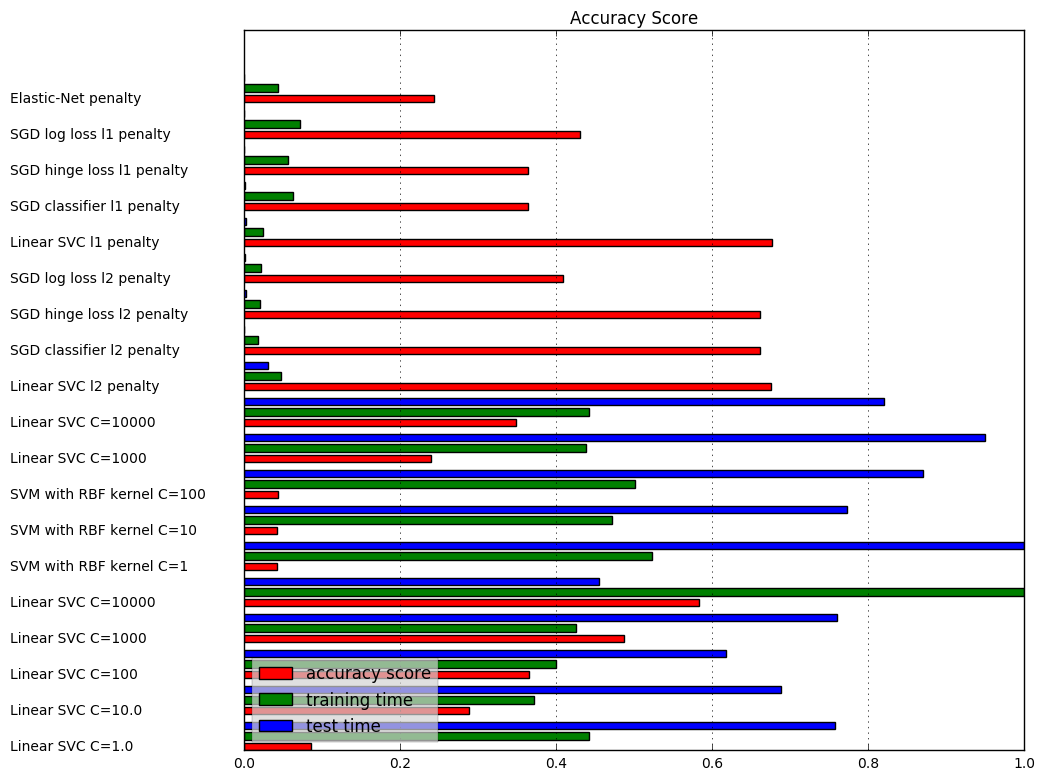

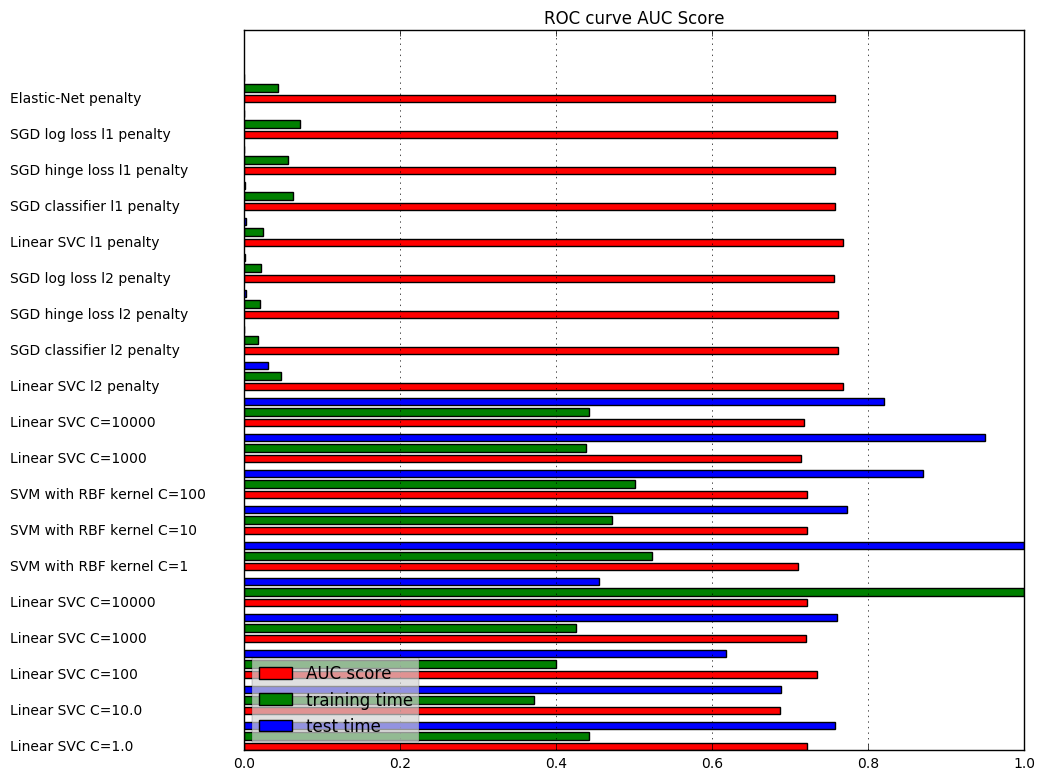

In [14]:
# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())

In [12]:
# Function to compute ROC curve and ROC area for each class
# based on the example in SciKitLearn
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

def plot_ROC_curve(y_test, y_score):
    """
    y_test - truth series, single array
    y_score - prediction series, single array
    
    yields: plot of curve
    The function will plot the ROC curve and an embedded legend with the AUC score.
    """
    sw_test = weight(y_test)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    fpr, tpr, _ = roc_curve(y_test, y_score, sample_weight=sw_test)
    roc_auc = auc(fpr, tpr)
    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0:0.3f})' .format(roc_auc), linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic curve')
    plt.legend(loc="lower right")
    plt.show()

# Compute Precision-Recall and plot curve
# As above, based on the SciKit Learn example

def plot_PR_curve(y_test, y_score):
    """
    y_test - truth series, single array
    y_score - prediction series, single array
    
    yields: plot of curve
    The function will plot the precision recall curve and an embedded legend with the AUC score.
    """
    sw_test = weight(y_test)
    
    precision = dict()
    recall = dict()
    precision, recall, _ = precision_recall_curve(y_test, y_score, pos_label=1, sample_weight=sw_test)
    
    # Plot Precision-Recall curve for each class
    plt.clf()
    plt.plot(recall, precision, label='Precision-recall curve')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve')
    plt.legend(loc="lower right")
    plt.show()

# Convenience function to adjust plot parameters for a clear layout.
target_names = ["Excluded", "Included"]

def show_confusion_matrix(cm):
    """
    cm - confusion matrix parameters as output from confusion_matrix() function
    
    yields: a plot of the confusion matrix with imshow
    Convenience function to adjust confusion matrix plot parameters for a clear layout.
    """
    sw_test = weight(y_test)
    
    plt.figure(figsize=(5, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary)
    plt.title('Confusion matrix')
    plt.set_cmap('Blues')
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=60)
    plt.yticks(tick_marks, target_names)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

def print_stats(clf, x_train, x_test, y_train, y_test):
    """
    clf - classifier
    x_train - matrix of training features
    x_test - matrix of training features
    y_train - array of training labels
    y_test - array of validation truths
    yields: print outs of the full suite of metrics for the classification for both training and validation sets
    """
    print(clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_train)

    print("Number of mislabeled points out of a total %d training points : %d"
          % (x_train.shape[0],(y_train != y_pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the training set: ", clf.score(x_train, y_train)), '\n')
    scores1 = cross_val_score(clf, x_train, y_train, cv=2, scoring = 'accuracy' , n_jobs = 1)
    scores2 = cross_val_score(clf, x_train, y_train, cv=2, scoring = 'f1' , n_jobs = 1)
    report = precision_recall_fscore_support(y_train, y_pred, average='macro')
    acc_score = accuracy_score(y_train, y_pred)#, sample_weight=sw_test)
    cm = confusion_matrix(y_pred, y_train)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], report[2], acc_score))
    print("\n10-fold CV mean accuracy = %0.3f, mean F1 = %0.3f\n" % 
          (scores1.mean(), scores2.mean()))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the training set: \n",pd.DataFrame(cm) )
    show_confusion_matrix(cm)

    pred = clf.predict(x_test)

    print("Number of mislabeled points out of a total %d testing points : %d"
          % (x_test.shape[0],(y_test != pred).sum()))
    # Output the hit-rate and the confusion matrix for the training set
    print(("The hit rate on the testing set: ", clf.score(x_test, y_test)), '\n')
    report = precision_recall_fscore_support(y_test, pred, average='macro')
    acc_score = accuracy_score(y_test, pred)
    cm = confusion_matrix(pred, y_test)

    print("\nprecision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f\n" % 
          (report[0], report[1], report[2], acc_score))
    print(pd.DataFrame(cm.astype(np.float64) / cm.sum(axis=1)),"\n")
    print("The confusion matrix on the testing set: \n",pd.DataFrame(cm))
    show_confusion_matrix(cm)

In [13]:
#RANDOM_STATE = 55
TEST_SIZE = 0.4

def run_class(X, y, TEST_SIZE):
    """
    X - input matrix of features for the classification
    y - array of truths for the classification 
    TEST_SIZE - number or proportion to use for the test set - int is number, float is precentage
    
    yields: this version runs a battery of classifiers. For each of them, it  
    prints out the performance metrics for the classification and plots the ROC and PR curves
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)    
    
    sw_test = weight(y_test)
    
    for clf, name in (
                        (Perceptron(n_iter=50, random_state=RANDOM_STATE, class_weight='balanced'), "Perceptron50"),
            (Perceptron(n_iter=50, random_state=RANDOM_STATE, class_weight='balanced', penalty = 'l1'), "Perceptron50l1"),
            (Perceptron(n_iter=50, random_state=RANDOM_STATE, class_weight='balanced', penalty="l2"), "Perceptron50l2"),
            (Perceptron(n_iter=20, random_state=RANDOM_STATE, class_weight='balanced'), "Perceptron20"),
            (Perceptron(n_iter=20, random_state=RANDOM_STATE, class_weight='balanced', penalty = 'l1'), "Perceptron20l1"),
            (Perceptron(n_iter=20, random_state=RANDOM_STATE, class_weight='balanced', penalty="l2"), "Perceptron20l2"),
            (linear_model.LogisticRegression(C=1e2, random_state=RANDOM_STATE, class_weight='balanced'), "Logistic Regression 1e2"),
            (linear_model.LogisticRegression(C=1e6, random_state=RANDOM_STATE, class_weight='balanced'), "Logistic Regression 1e6"),
            (LinearSVC(C = 1.0, penalty="l2", multi_class = 'crammer_singer', random_state=RANDOM_STATE, class_weight='balanced'), 
             "LinearSVC1 L2 penalty"), 
            (LinearSVC(C = 1000, penalty="l2", random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC1000 L2 penalty"),
            (LinearSVC(C = 100, penalty="l2", random_state=RANDOM_STATE, class_weight='balanced'), "LinearSVC100 L2 penalty"),
            (LinearSVC(C = 1.0, penalty="l1", multi_class = 'crammer_singer', random_state=RANDOM_STATE, class_weight='balanced'), 
             "LinearSVC1 L1 penalty"), 
            (LinearSVC(C = 1000, penalty="l1", dual = False, random_state=RANDOM_STATE, class_weight='balanced'), 
             "LinearSVC1000 L1 penalty"),
            (LinearSVC(C = 100, penalty="l1", dual = False, random_state=RANDOM_STATE, class_weight='balanced'), 
             "LinearSVC100 L1 penalty"),
            (SVC(kernel="linear", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1.0"),
            (SVC(kernel="linear", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=10.0"),
            (SVC(kernel="linear", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=100.0"),
            (SVC(kernel="linear", C=1000.0, random_state=RANDOM_STATE, class_weight='balanced'), "Linear SVC C=1000.0"),
            
            (SVC(kernel="rbf", C=1.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=1"),
            (SVC(kernel="rbf", C=10.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=10"),
            (SVC(kernel="rbf", C=100.0, random_state=RANDOM_STATE, class_weight='balanced'), "SVM with RBF kernel C=100"),
            (MLPClassifier(hidden_layer_sizes=(5, 5), learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, 
                           max_iter=200, shuffle=True, random_state=RANDOM_STATE, validation_fraction=0.2), "MLP5adaptive"),
            (MLPClassifier(hidden_layer_sizes=(10, 10), learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, 
                           max_iter=200, shuffle=True, random_state=RANDOM_STATE, validation_fraction=0.2), "MLP5adaptive"),
            (MLPClassifier(hidden_layer_sizes=(20, 20), learning_rate='adaptive', learning_rate_init=0.001, power_t=0.5, 
                           max_iter=200, shuffle=True, random_state=RANDOM_STATE, validation_fraction=0.2), "MLP5adaptive"),
            (MLPClassifier(hidden_layer_sizes=(5, 5), learning_rate='invscaling', learning_rate_init=0.001, power_t=0.5, 
                           max_iter=200, shuffle=True, random_state=RANDOM_STATE, validation_fraction=0.2), "MLP5adaptive"),
            ):
        
        print("\n", name, "\ntest size is %d %%  " % (TEST_SIZE*100))

        clf.fit(X_train, y_train)
        print (clf.score(X_test, y_test))
        
        mean_acc_score = clf.score(X_test, y_test)
        pred = clf.predict(X_test)

        report = precision_recall_fscore_support(y_test, pred, average='binary', sample_weight=sw_test)
        acc_score = accuracy_score(y_test, pred)
        cm = confusion_matrix(pred, y_test)

        # get the decision boundary or the probas.
        if hasattr(clf, "decision_function"):
            y_score = np.array(clf.decision_function(X_test))
        else:
            y_score = clf.predict_proba(X_test)[:,1]

        auc_score = metrics.roc_auc_score(y_test, y_score, sample_weight=sw_test)

        #print("mean_accuracy = %0.3f" % mean_acc_score)
        print("precision = %0.3f, recall = %0.3f, F1 = %0.3f, accuracy = %0.3f" % 
              (report[0], report[1], report[2], acc_score))
        print("The confusion matrix on the testing set:          \n", pd.DataFrame(cm))
        print("*********** AUC for ROC = %0.3f" % auc_score)
                
        plot_ROC_curve(y_test, y_score)
        plot_PR_curve(y_test, y_score)
        #print (y_score[:,:30])

In [13]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'class_weight':['balanced', None],
                     'random_state':[55, 21, 71, 35, 61],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000], 'random_state':[55, 21, 71, 35, 61],'class_weight':['balanced', None]}]

scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
{'kernel': 'linear', 'C': 10, 'random_state': 55, 'class_weight': 'balanced'}
()
Grid scores on development set:
()
0.500 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 55, 'gamma': 0.001, 'class_weight': 'balanced'}
0.500 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 21, 'gamma': 0.001, 'class_weight': 'balanced'}
0.500 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 71, 'gamma': 0.001, 'class_weight': 'balanced'}
0.500 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 35, 'gamma': 0.001, 'class_weight': 'balanced'}
0.500 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 61, 'gamma': 0.001, 'class_weight': 'balanced'}
0.500 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 55, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.500 (+/-0.000) for {'kernel': 'rbf', 'C': 1, 'random_state': 21, 'gamma': 0.0001, 'class_weight': 'balanced'}
0.500 (+/-0.000)

In [14]:
# Set the parameters by cross-validation
#linearsvc


tuned_parameters = [{'C': [1.0, 10, 100, 1000],
                     #'penalty': ['l2', 'l1'],
                     'class_weight':['balanced', None],
                     #'loss': ['squared_hinge', 'hinge'],
                     'random_state':[55, 21, 71, 35, 61],
                     #'dual': [True, False],
                     'multi_class': ['crammer_singer', 'ovr']
                     }]

                    
scores = ['recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(LinearSVC(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for recall
()
Best parameters set found on development set:
()
{'multi_class': 'ovr', 'C': 10, 'random_state': 35, 'class_weight': 'balanced'}
()
Grid scores on development set:
()
0.674 (+/-0.052) for {'multi_class': 'crammer_singer', 'C': 1.0, 'random_state': 55, 'class_weight': 'balanced'}
0.674 (+/-0.052) for {'multi_class': 'crammer_singer', 'C': 1.0, 'random_state': 21, 'class_weight': 'balanced'}
0.674 (+/-0.052) for {'multi_class': 'crammer_singer', 'C': 1.0, 'random_state': 71, 'class_weight': 'balanced'}
0.674 (+/-0.052) for {'multi_class': 'crammer_singer', 'C': 1.0, 'random_state': 35, 'class_weight': 'balanced'}
0.674 (+/-0.052) for {'multi_class': 'crammer_singer', 'C': 1.0, 'random_state': 61, 'class_weight': 'balanced'}
0.672 (+/-0.093) for {'multi_class': 'ovr', 'C': 1.0, 'random_state': 55, 'class_weight': 'balanced'}
0.672 (+/-0.093) for {'multi_class': 'ovr', 'C': 1.0, 'random_state': 21, 'class_weight': 'balanced'}
0.672 (+/-0.093) for {'m

In [15]:
# Set the parameters by cross-validation
#PERCEPTRON
tuned_parameters = [{'n_iter': [2, 5, 10,50],
                     'penalty': [None, 'l2', 'l1', 'elasticnet'],
                     'alpha': [0.001, 0.0001, 0.00001],
                     'class_weight':['balanced', None]
                    }]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(Perceptron(), tuned_parameters, cv=2, scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(metrics.classification_report(y_true, y_pred))
    print()

# Tuning hyper-parameters for precision
()
Best parameters set found on development set:
()
{'penalty': None, 'alpha': 0.001, 'n_iter': 50, 'class_weight': None}
()
Grid scores on development set:
()
0.525 (+/-0.006) for {'penalty': None, 'alpha': 0.001, 'n_iter': 2, 'class_weight': 'balanced'}
0.531 (+/-0.003) for {'penalty': 'l2', 'alpha': 0.001, 'n_iter': 2, 'class_weight': 'balanced'}
0.557 (+/-0.051) for {'penalty': 'l1', 'alpha': 0.001, 'n_iter': 2, 'class_weight': 'balanced'}
0.531 (+/-0.003) for {'penalty': 'elasticnet', 'alpha': 0.001, 'n_iter': 2, 'class_weight': 'balanced'}
0.553 (+/-0.056) for {'penalty': None, 'alpha': 0.001, 'n_iter': 5, 'class_weight': 'balanced'}
0.570 (+/-0.080) for {'penalty': 'l2', 'alpha': 0.001, 'n_iter': 5, 'class_weight': 'balanced'}
0.500 (+/-0.052) for {'penalty': 'l1', 'alpha': 0.001, 'n_iter': 5, 'class_weight': 'balanced'}
0.570 (+/-0.080) for {'penalty': 'elasticnet', 'alpha': 0.001, 'n_iter': 5, 'class_weight': 'balanced'}
0.562 (+/-0.053)

In [ ]:
##run 2

Perceptron50
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=50, n_jobs=1, penalty=None,
      random_state=61, shuffle=True, verbose=0, warm_start=False)
train time: 0.615s
test time:  0.067s
accuracy:   0.937
precision:  0.269
recall:     0.095
*** AUC for ROC = 0.757

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.95      0.99      0.97      1287
   Relevant       0.27      0.09      0.14        74

avg / total       0.91      0.94      0.92      1361

confusion matrix:
[[1268   19]
 [  67    7]]
()
Perceptron50l1
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=50, n_jobs=1, penalty='l1',
      random_state=61, shuffle=True, verbose=0, warm_start=False)
train time:

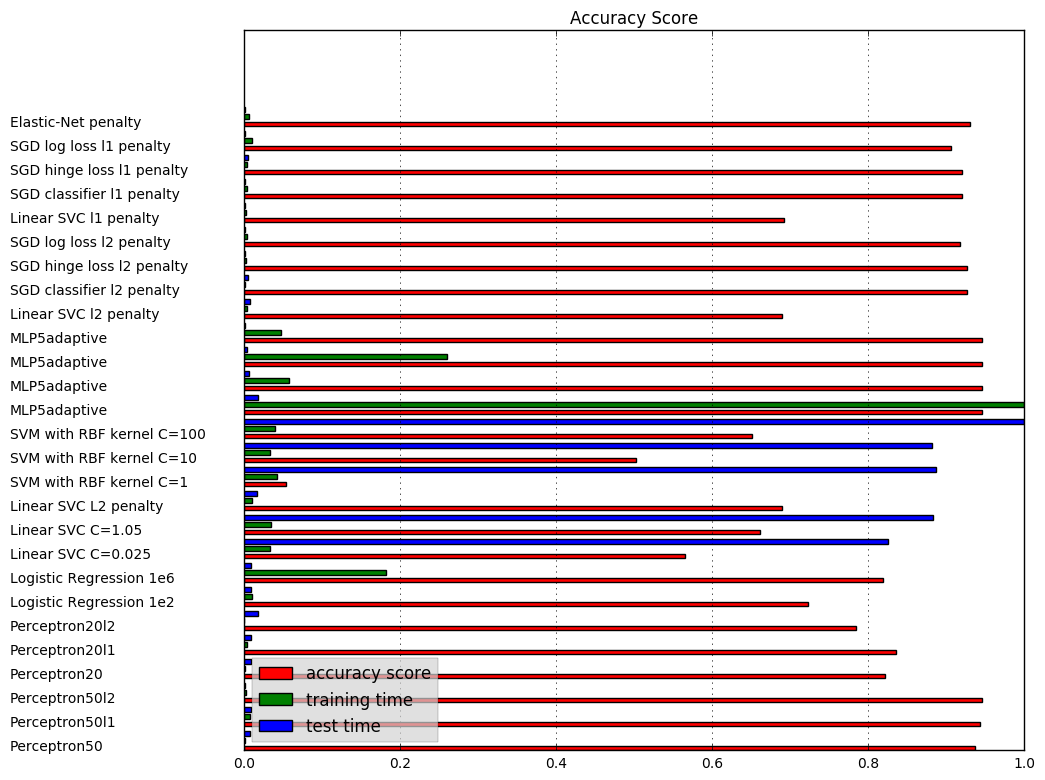

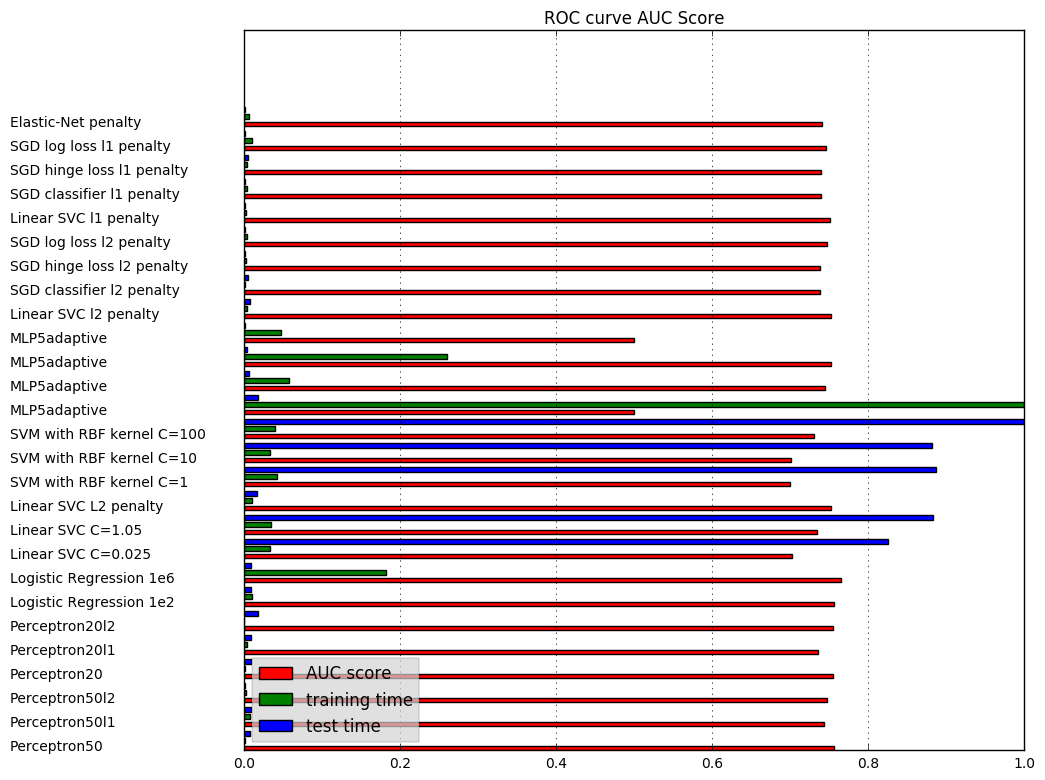

('\n', 'Perceptron50', '\ntest size is 40 %  ')
0.916972814107
precision = 0.576, recall = 0.270, F1 = 0.368, accuracy = 0.917
('The confusion matrix on the testing set:          \n',       0   1
0  1228  54
1    59  20)
*********** AUC for ROC = 0.759


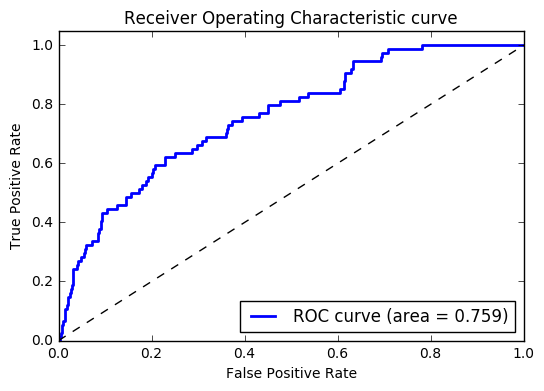

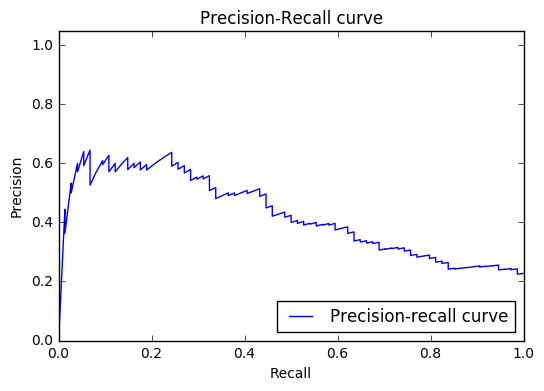

('\n', 'Perceptron50l1', '\ntest size is 40 %  ')
0.944158706833
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.944
('The confusion matrix on the testing set:          \n',       0   1
0  1285  74
1     2   0)
*********** AUC for ROC = 0.750


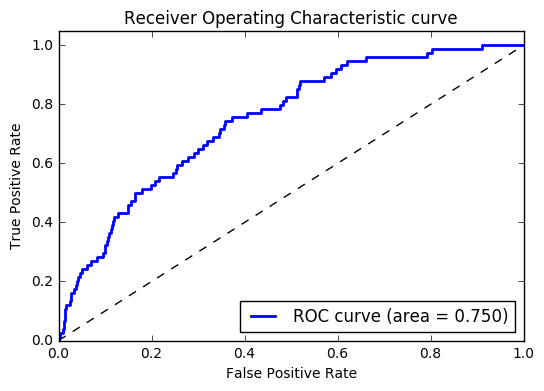

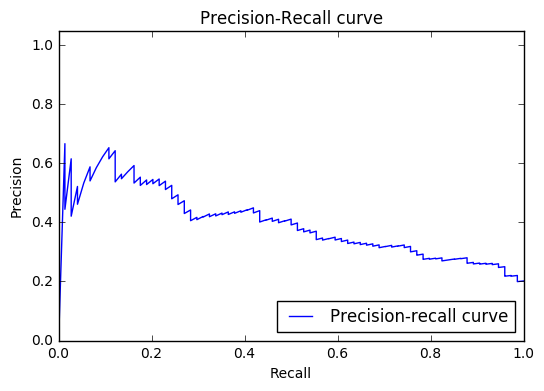

('\n', 'Perceptron50l2', '\ntest size is 40 %  ')
0.929463629684
precision = 0.643, recall = 0.243, F1 = 0.353, accuracy = 0.929
('The confusion matrix on the testing set:          \n',       0   1
0  1247  56
1    40  18)
*********** AUC for ROC = 0.749


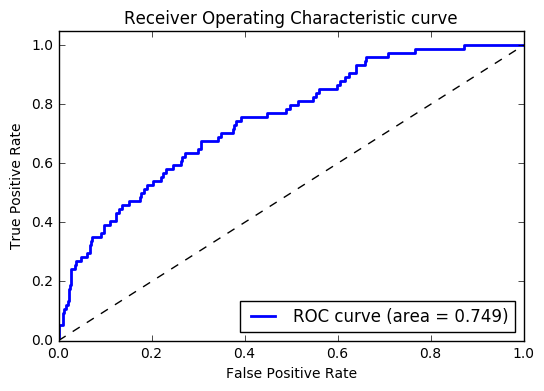

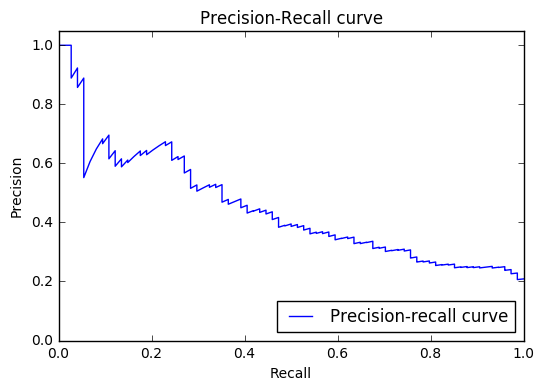

('\n', 'Perceptron20', '\ntest size is 40 %  ')
0.858192505511
precision = 0.459, recall = 0.432, F1 = 0.445, accuracy = 0.858
('The confusion matrix on the testing set:          \n',       0   1
0  1136  42
1   151  32)
*********** AUC for ROC = 0.744


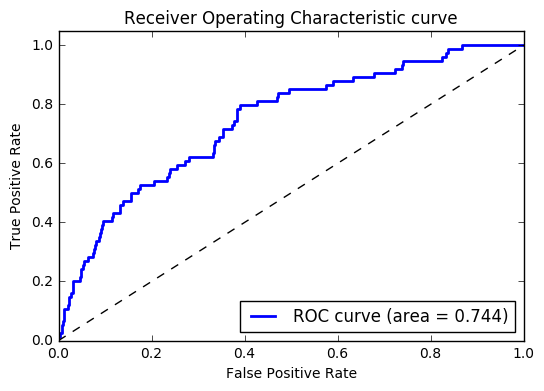

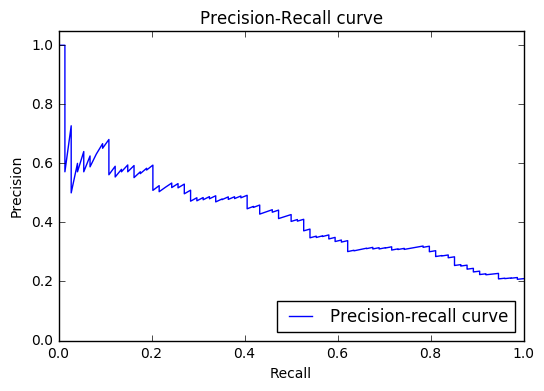

('\n', 'Perceptron20l1', '\ntest size is 40 %  ')
0.844232182219
precision = 0.436, recall = 0.446, F1 = 0.441, accuracy = 0.844
('The confusion matrix on the testing set:          \n',       0   1
0  1116  41
1   171  33)
*********** AUC for ROC = 0.750


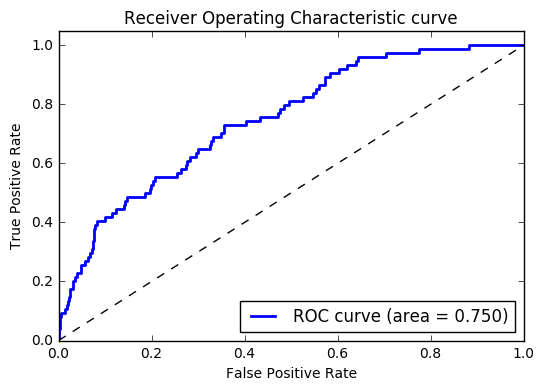

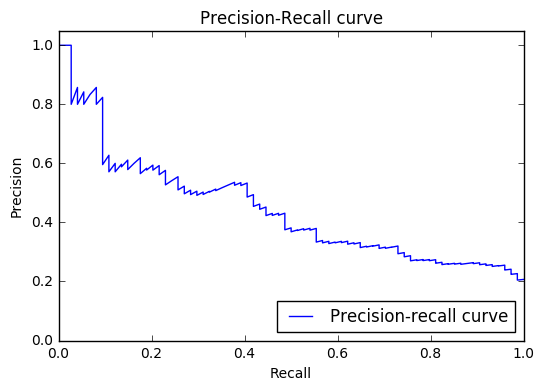

('\n', 'Perceptron20l2', '\ntest size is 40 %  ')
0.659808963997
precision = 0.305, recall = 0.649, F1 = 0.415, accuracy = 0.660
('The confusion matrix on the testing set:          \n',      0   1
0  850  26
1  437  48)
*********** AUC for ROC = 0.741


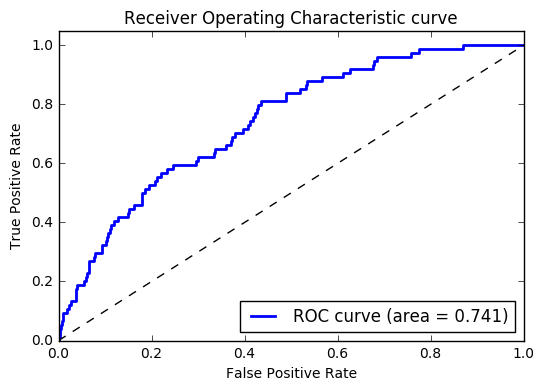

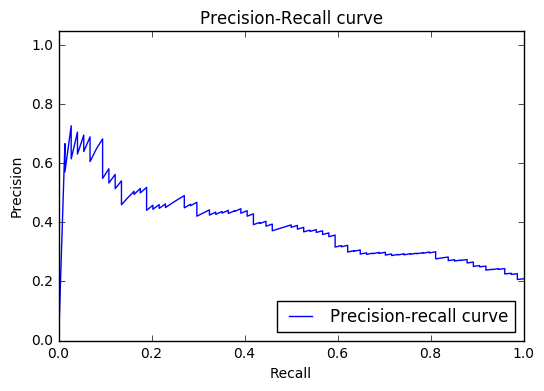

('\n', 'Logistic Regression 1e2', '\ntest size is 40 %  ')
0.720058780309
precision = 0.351, recall = 0.649, F1 = 0.456, accuracy = 0.720
('The confusion matrix on the testing set:          \n',      0   1
0  932  26
1  355  48)
*********** AUC for ROC = 0.760


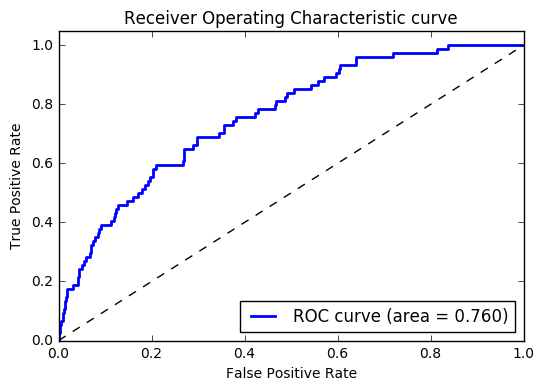

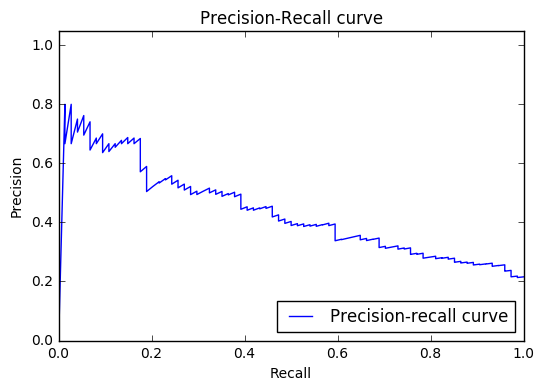

('\n', 'Logistic Regression 1e6', '\ntest size is 40 %  ')
0.822189566495
precision = 0.430, recall = 0.527, F1 = 0.473, accuracy = 0.822
('The confusion matrix on the testing set:          \n',       0   1
0  1080  35
1   207  39)
*********** AUC for ROC = 0.769


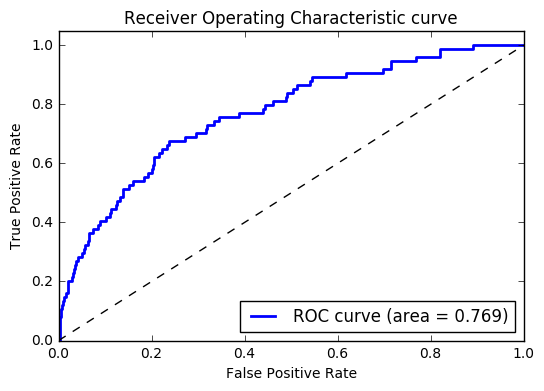

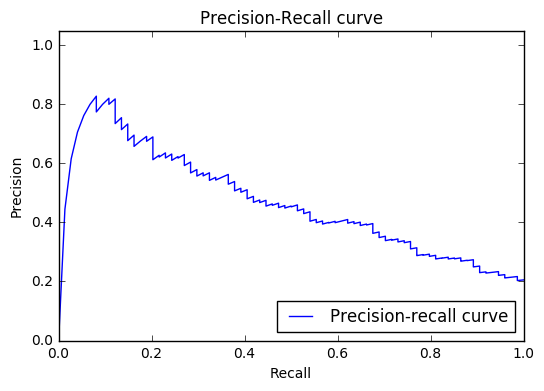

('\n', 'Linear SVC C=0.025', '\ntest size is 40 %  ')
0.51726671565
precision = 0.263, recall = 0.770, F1 = 0.392, accuracy = 0.517
('The confusion matrix on the testing set:          \n',      0   1
0  647  17
1  640  57)
*********** AUC for ROC = 0.703


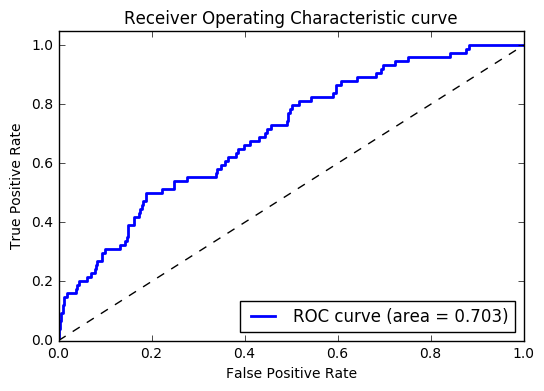

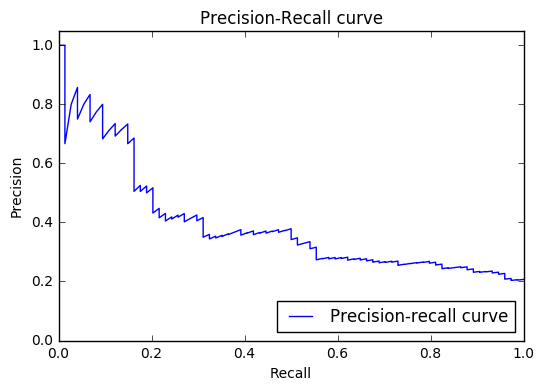

('\n', 'Linear SVC C=1.05', '\ntest size is 40 %  ')
0.697281410727
precision = 0.324, recall = 0.622, F1 = 0.426, accuracy = 0.697
('The confusion matrix on the testing set:          \n',      0   1
0  903  28
1  384  46)
*********** AUC for ROC = 0.740


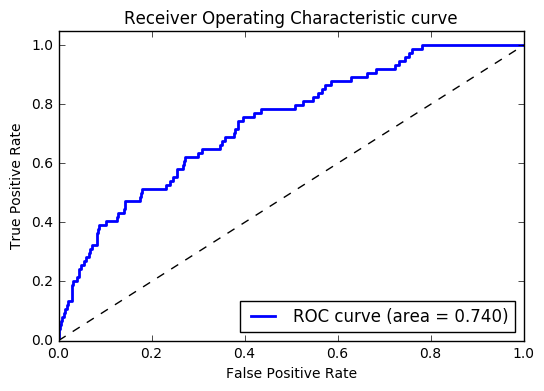

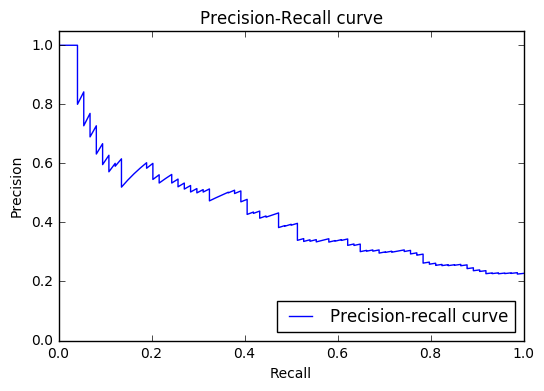

('\n', 'Linear SVC L2 penalty', '\ntest size is 40 %  ')
0.689933872153
precision = 0.314, recall = 0.608, F1 = 0.414, accuracy = 0.690
('The confusion matrix on the testing set:          \n',      0   1
0  894  29
1  393  45)
*********** AUC for ROC = 0.753


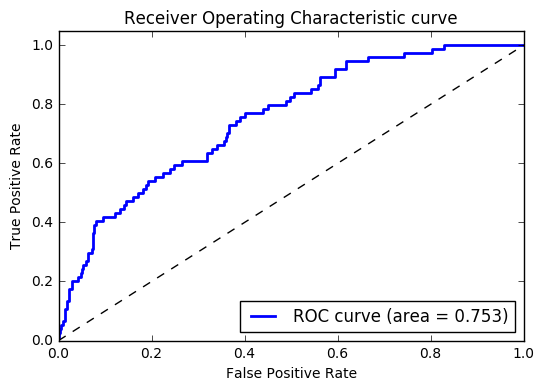

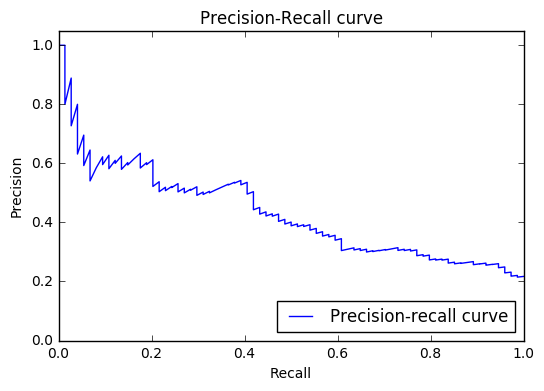

('\n', 'SVM with RBF kernel C=1', '\ntest size is 40 %  ')
0.945628214548
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.946
('The confusion matrix on the testing set:          \n',       0   1
0  1287  74
1     0   0)
*********** AUC for ROC = 0.702


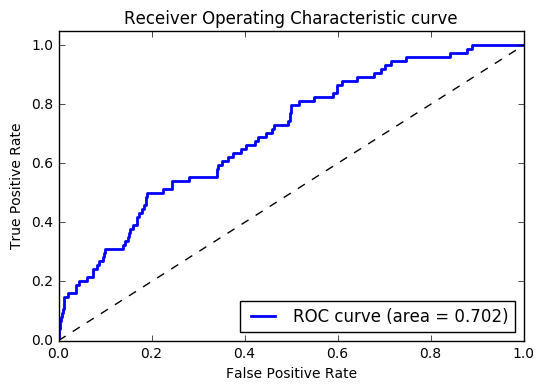

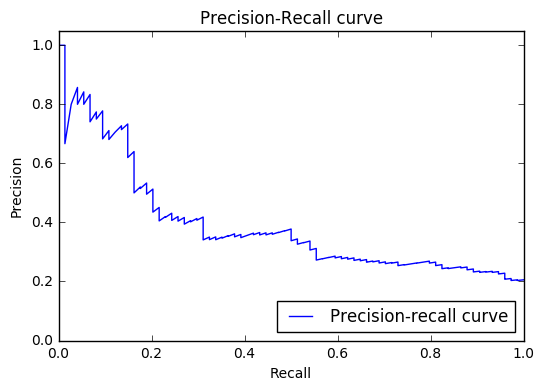

('\n', 'SVM with RBF kernel C=10', '\ntest size is 40 %  ')
0.419544452608
precision = 0.247, recall = 0.865, F1 = 0.384, accuracy = 0.420
('The confusion matrix on the testing set:          \n',      0   1
0  507  10
1  780  64)
*********** AUC for ROC = 0.702


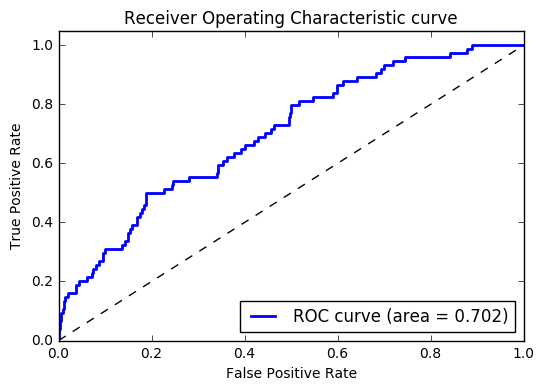

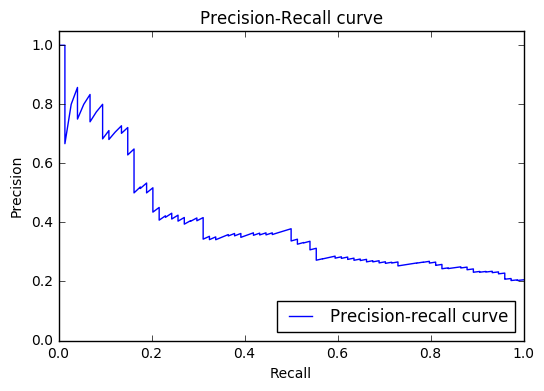

('\n', 'SVM with RBF kernel C=100', '\ntest size is 40 %  ')
0.638501102131
precision = 0.303, recall = 0.689, F1 = 0.421, accuracy = 0.639
('The confusion matrix on the testing set:          \n',      0   1
0  818  23
1  469  51)
*********** AUC for ROC = 0.733


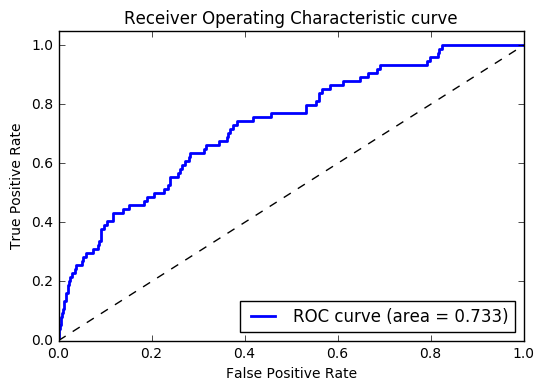

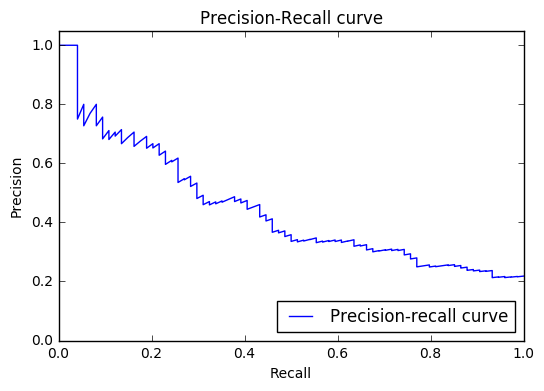

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.945628214548
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.946
('The confusion matrix on the testing set:          \n',       0   1
0  1287  74
1     0   0)
*********** AUC for ROC = 0.500


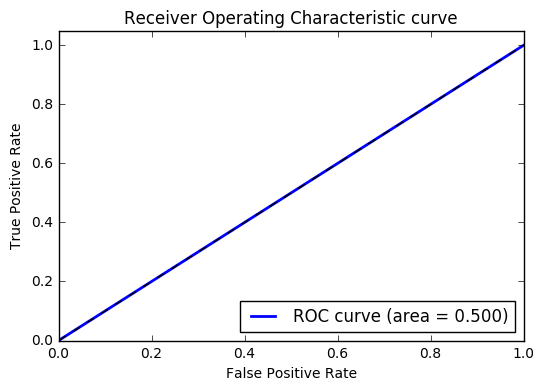

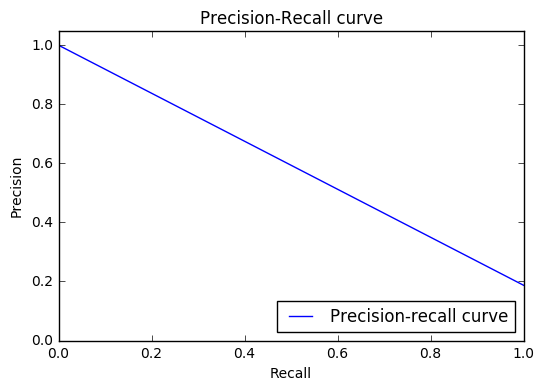

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.945628214548
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.946
('The confusion matrix on the testing set:          \n',       0   1
0  1287  74
1     0   0)
*********** AUC for ROC = 0.745


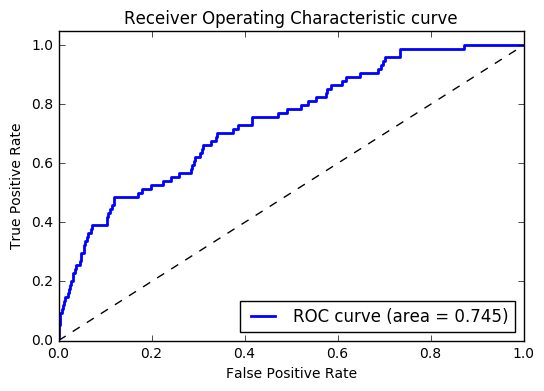

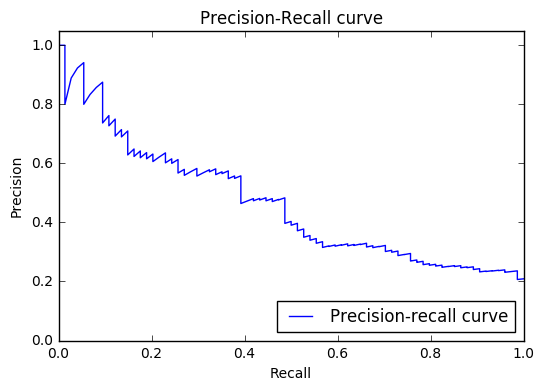

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.945628214548
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.946
('The confusion matrix on the testing set:          \n',       0   1
0  1287  74
1     0   0)
*********** AUC for ROC = 0.753


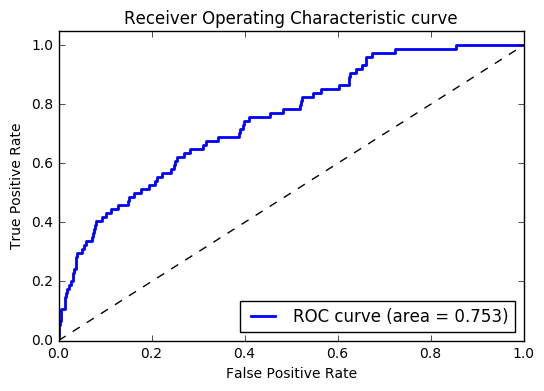

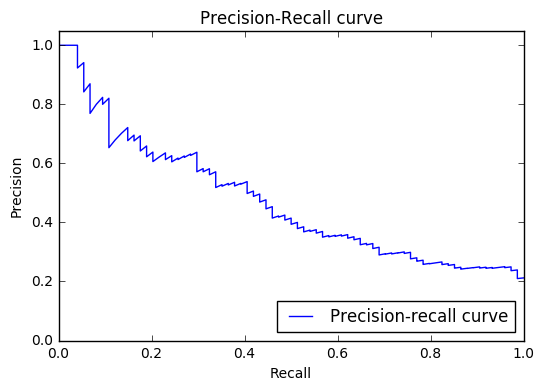

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.945628214548
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.946
('The confusion matrix on the testing set:          \n',       0   1
0  1287  74
1     0   0)
*********** AUC for ROC = 0.500


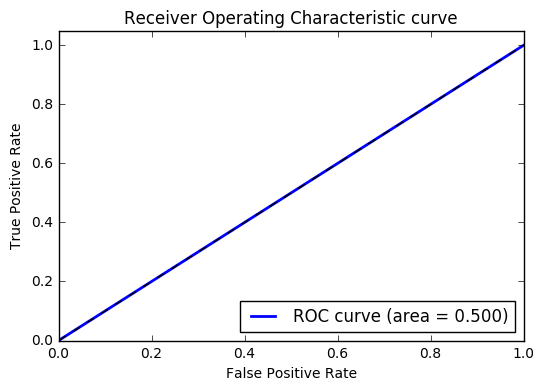

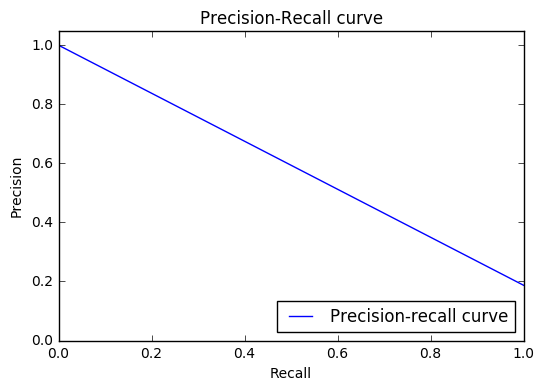

In [ ]:
RANDOM_STATE = 61


X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

Perceptron50
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=50, n_jobs=1, penalty=None,
      random_state=21, shuffle=True, verbose=0, warm_start=False)
train time: 0.205s
test time:  0.007s
accuracy:   0.065
precision:  0.051
recall:     1.000
*** AUC for ROC = 0.771

classification report:
             precision    recall  f1-score   support

 Irrelevant       1.00      0.02      0.03      1292
   Relevant       0.05      1.00      0.10        69

avg / total       0.95      0.07      0.03      1361

confusion matrix:
[[  20 1272]
 [   0   69]]
()
Perceptron50l1
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=50, n_jobs=1, penalty='l1',
      random_state=21, shuffle=True, verbose=0, warm_start=False)
train time:

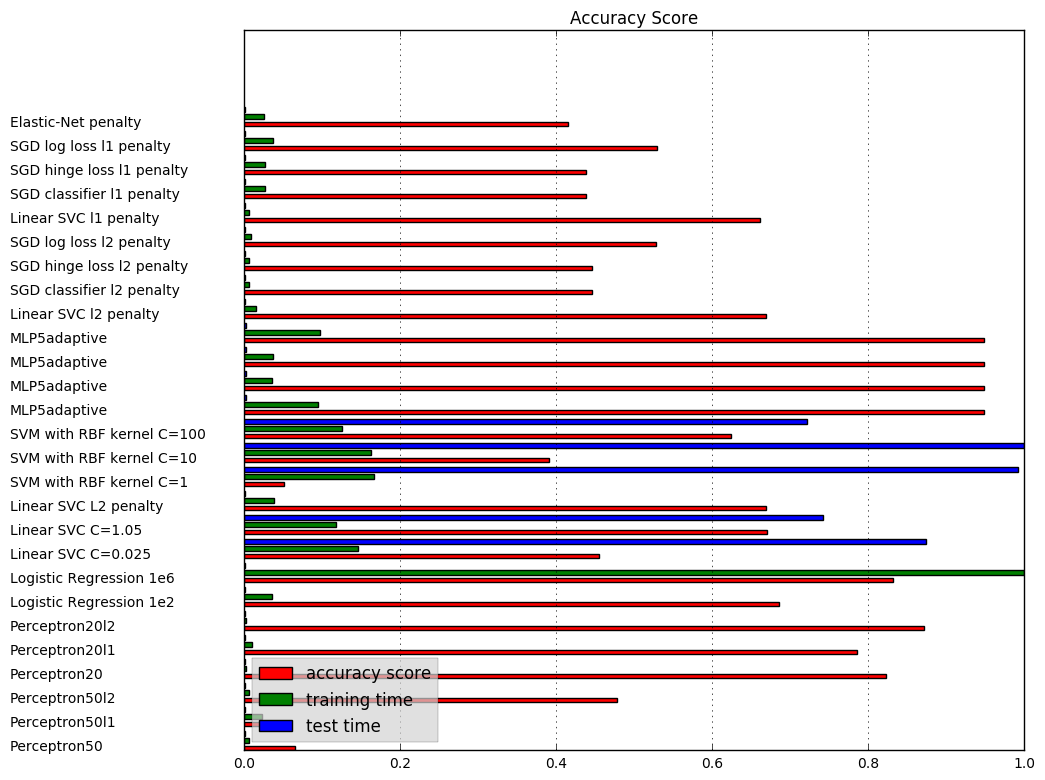

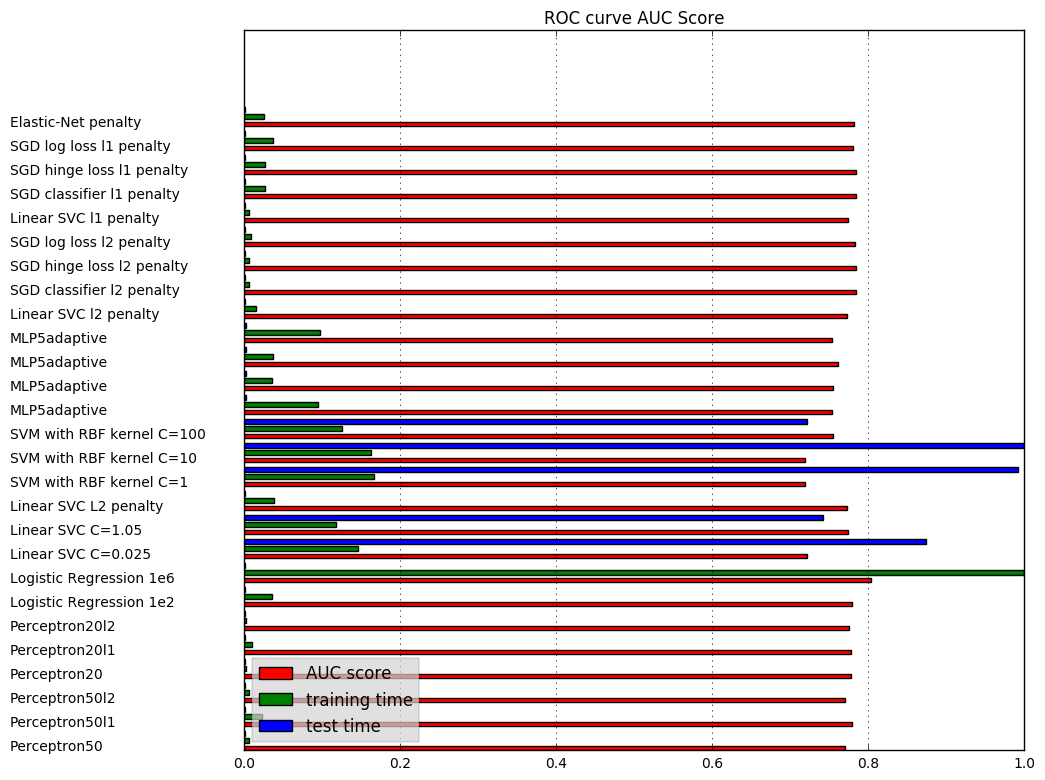

('\n', 'Perceptron50', '\ntest size is 40 %  ')
0.0675973548861
precision = 0.179, recall = 1.000, F1 = 0.303, accuracy = 0.068
('The confusion matrix on the testing set:          \n',       0   1
0    23   0
1  1269  69)
*********** AUC for ROC = 0.773


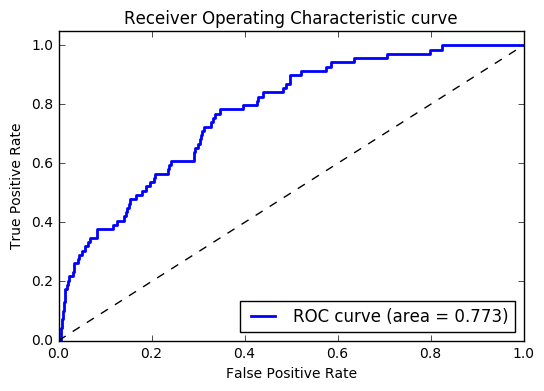

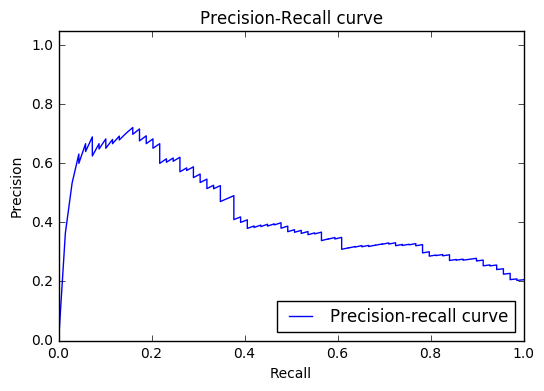

('\n', 'Perceptron50l1', '\ntest size is 40 %  ')
0.501102130786
precision = 0.258, recall = 0.841, F1 = 0.395, accuracy = 0.501
('The confusion matrix on the testing set:          \n',      0   1
0  624  11
1  668  58)
*********** AUC for ROC = 0.776


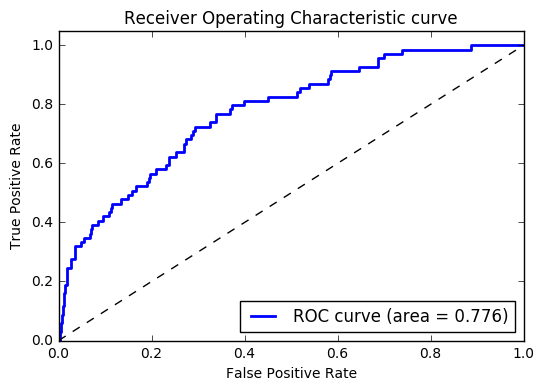

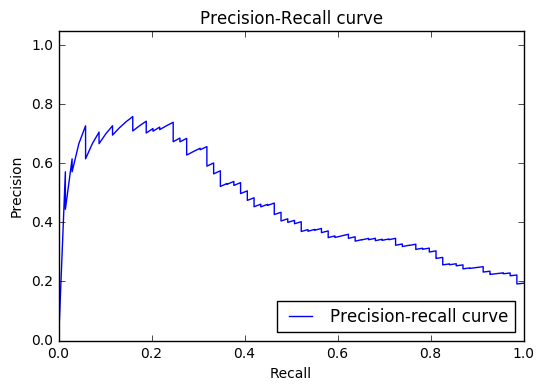

('\n', 'Perceptron50l2', '\ntest size is 40 %  ')
0.376928728876
precision = 0.230, recall = 0.913, F1 = 0.368, accuracy = 0.377
('The confusion matrix on the testing set:          \n',      0   1
0  450   6
1  842  63)
*********** AUC for ROC = 0.746


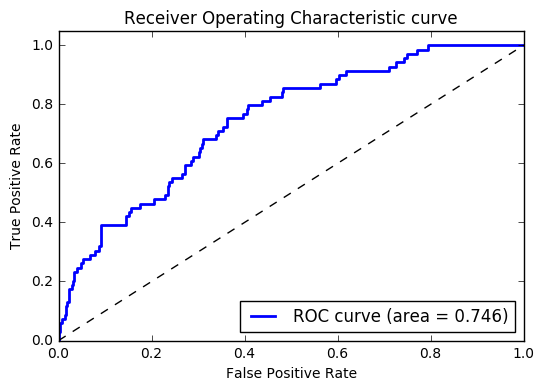

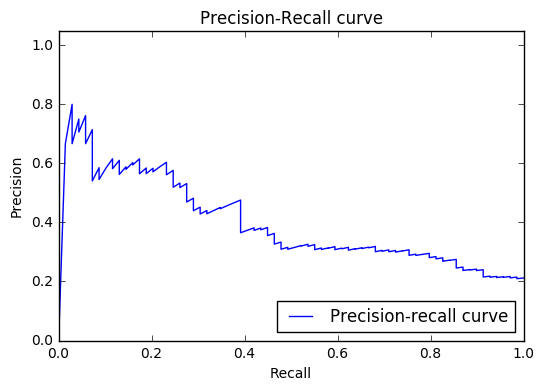

('\n', 'Perceptron20', '\ntest size is 40 %  ')
0.662747979427
precision = 0.301, recall = 0.681, F1 = 0.417, accuracy = 0.663
('The confusion matrix on the testing set:          \n',      0   1
0  855  22
1  437  47)
*********** AUC for ROC = 0.761


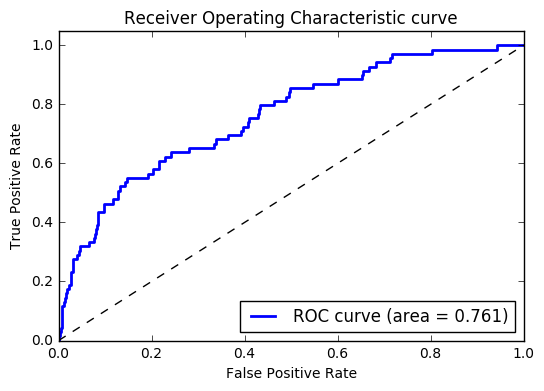

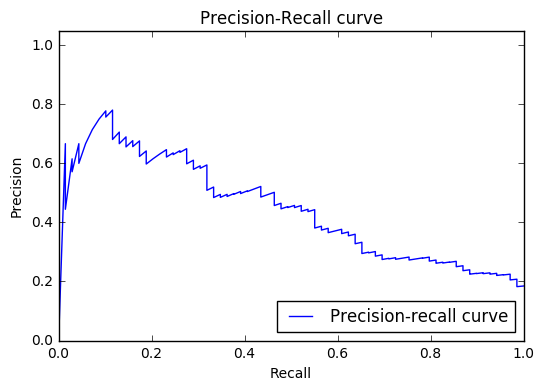

('\n', 'Perceptron20l1', '\ntest size is 40 %  ')
0.559147685525
precision = 0.273, recall = 0.797, F1 = 0.407, accuracy = 0.559
('The confusion matrix on the testing set:          \n',      0   1
0  706  14
1  586  55)
*********** AUC for ROC = 0.758


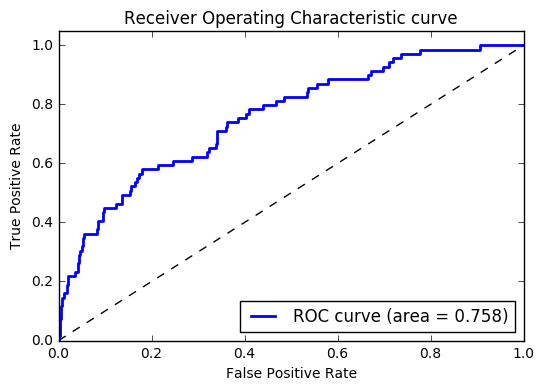

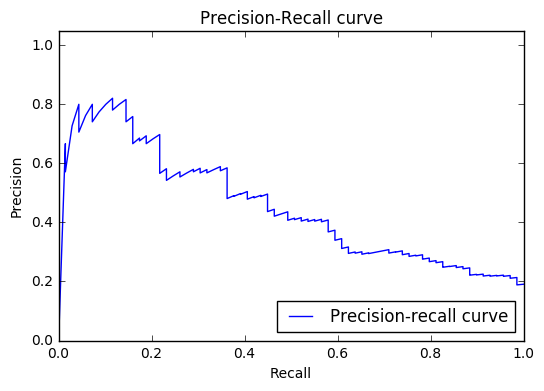

('\n', 'Perceptron20l2', '\ntest size is 40 %  ')
0.551800146951
precision = 0.270, recall = 0.797, F1 = 0.403, accuracy = 0.552
('The confusion matrix on the testing set:          \n',      0   1
0  696  14
1  596  55)
*********** AUC for ROC = 0.746


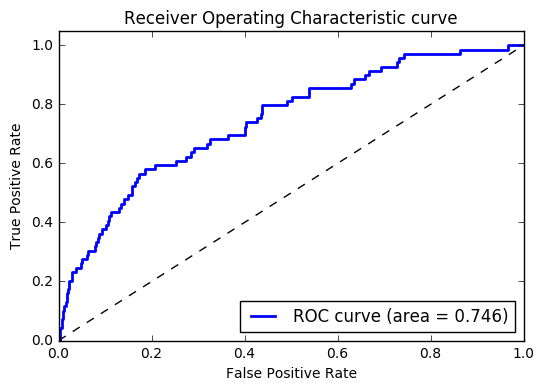

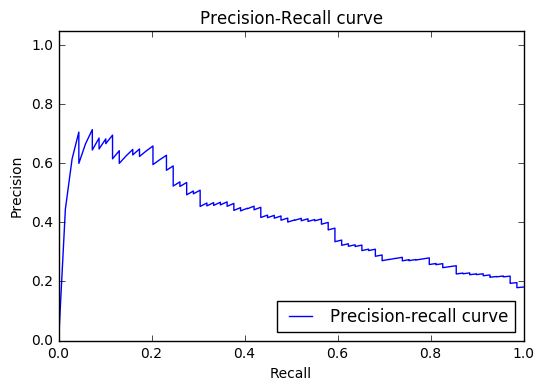

('\n', 'Logistic Regression 1e2', '\ntest size is 40 %  ')
0.691403379868
precision = 0.317, recall = 0.667, F1 = 0.429, accuracy = 0.691
('The confusion matrix on the testing set:          \n',      0   1
0  895  23
1  397  46)
*********** AUC for ROC = 0.776


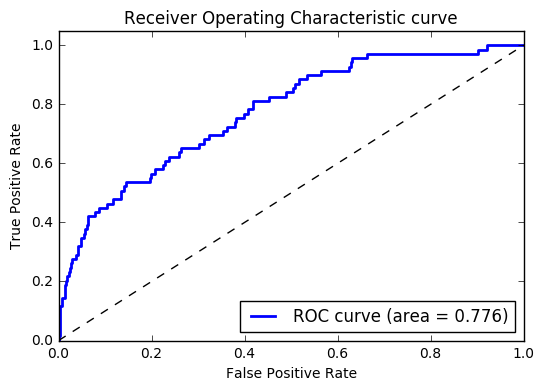

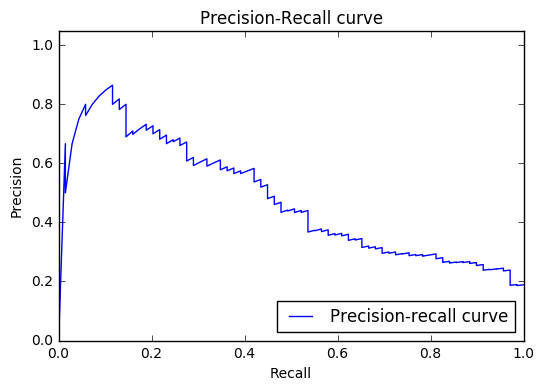

('\n', 'Logistic Regression 1e6', '\ntest size is 40 %  ')
0.827332843497
precision = 0.451, recall = 0.623, F1 = 0.524, accuracy = 0.827
('The confusion matrix on the testing set:          \n',       0   1
0  1083  26
1   209  43)
*********** AUC for ROC = 0.808


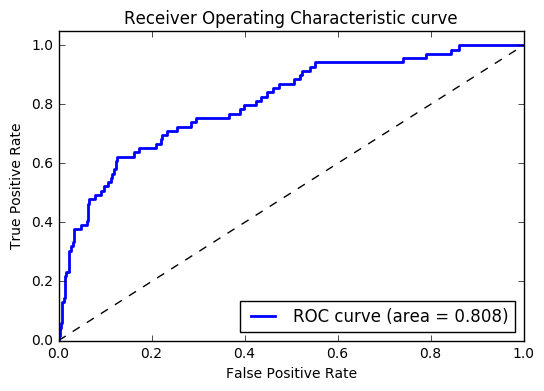

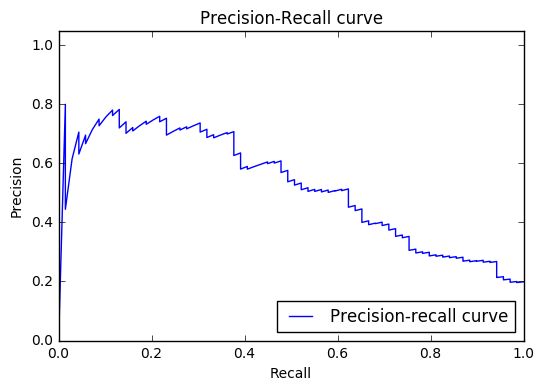

('\n', 'Linear SVC C=0.025', '\ntest size is 40 %  ')
0.508449669361
precision = 0.242, recall = 0.754, F1 = 0.366, accuracy = 0.508
('The confusion matrix on the testing set:          \n',      0   1
0  640  17
1  652  52)
*********** AUC for ROC = 0.707


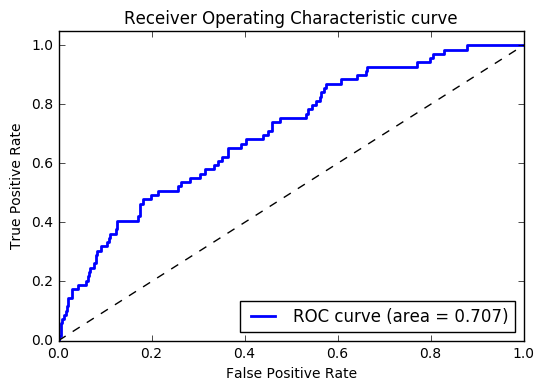

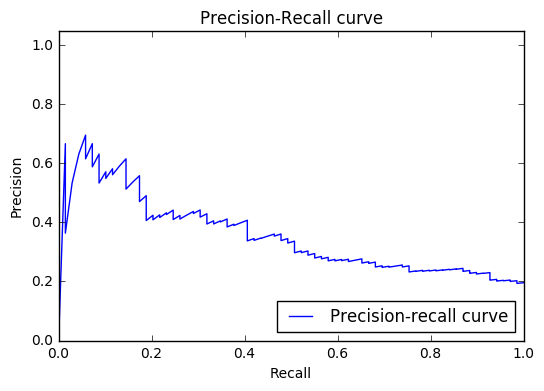

('\n', 'Linear SVC C=1.05', '\ntest size is 40 %  ')
0.661278471712
precision = 0.308, recall = 0.710, F1 = 0.429, accuracy = 0.661
('The confusion matrix on the testing set:          \n',      0   1
0  851  20
1  441  49)
*********** AUC for ROC = 0.770


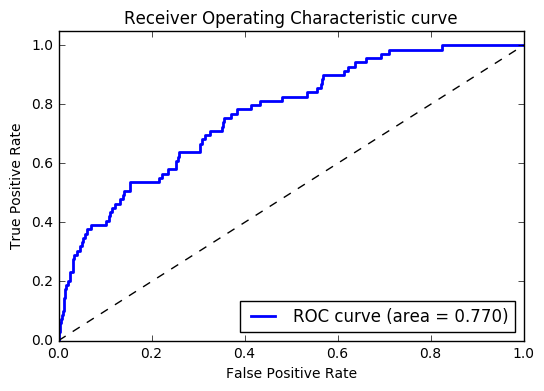

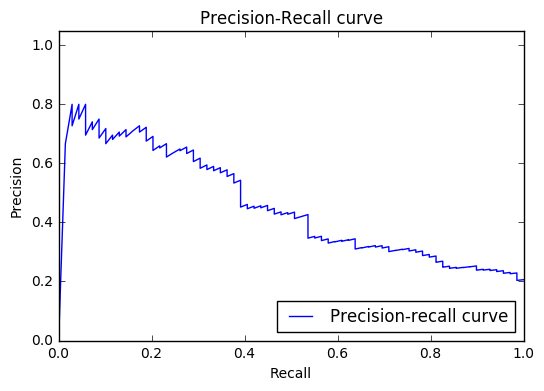

('\n', 'Linear SVC L2 penalty', '\ntest size is 40 %  ')
0.669360764144
precision = 0.301, recall = 0.667, F1 = 0.415, accuracy = 0.669
('The confusion matrix on the testing set:          \n',      0   1
0  865  23
1  427  46)
*********** AUC for ROC = 0.773


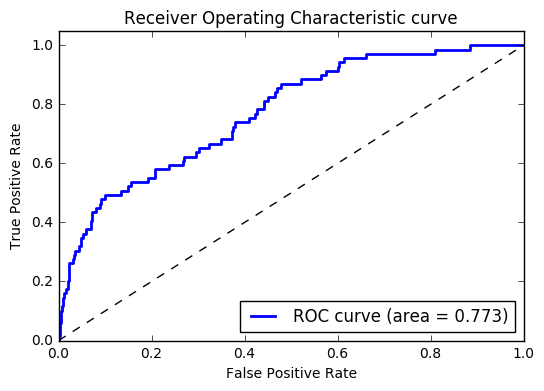

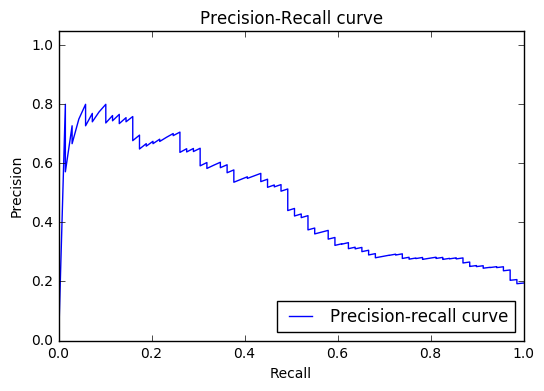

('\n', 'SVM with RBF kernel C=1', '\ntest size is 40 %  ')
0.949301983835
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.949
('The confusion matrix on the testing set:          \n',       0   1
0  1292  69
1     0   0)
*********** AUC for ROC = 0.705


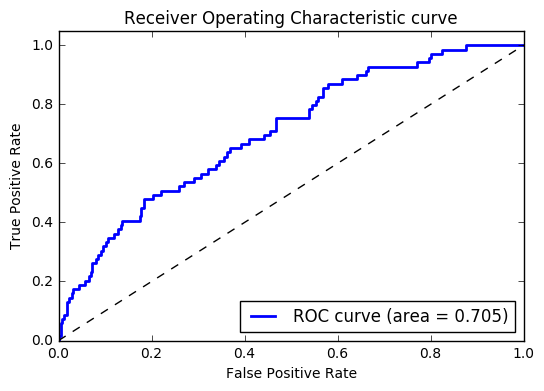

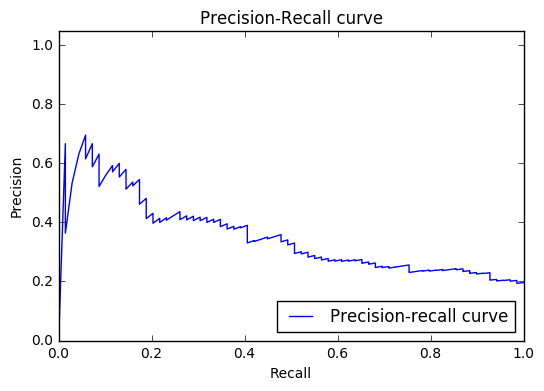

('\n', 'SVM with RBF kernel C=10', '\ntest size is 40 %  ')
0.425422483468
precision = 0.237, recall = 0.870, F1 = 0.372, accuracy = 0.425
('The confusion matrix on the testing set:          \n',      0   1
0  519   9
1  773  60)
*********** AUC for ROC = 0.705


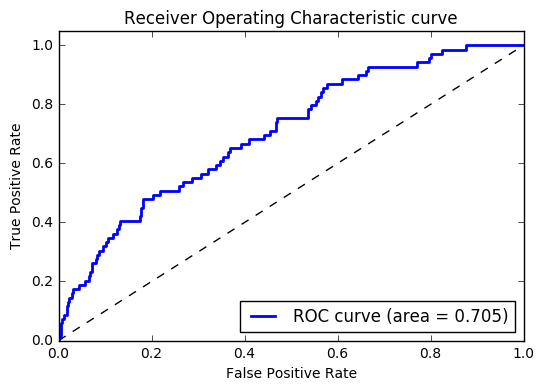

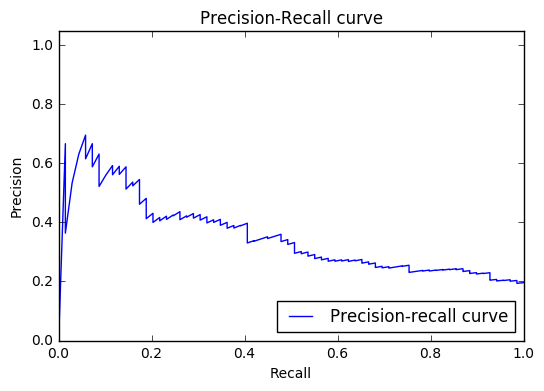

('\n', 'SVM with RBF kernel C=100', '\ntest size is 40 %  ')
0.65319617928
precision = 0.302, recall = 0.710, F1 = 0.424, accuracy = 0.653
('The confusion matrix on the testing set:          \n',      0   1
0  840  20
1  452  49)
*********** AUC for ROC = 0.745


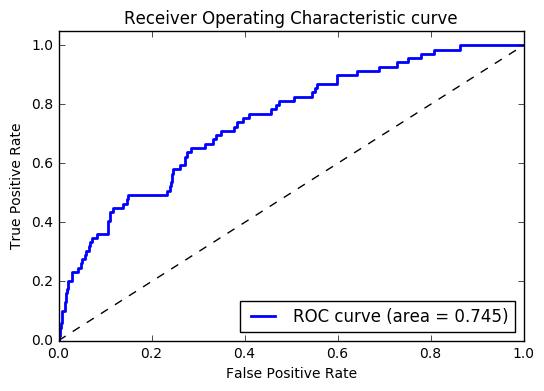

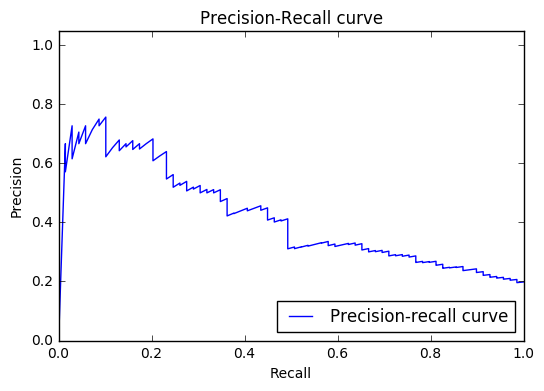

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.949301983835
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.949
('The confusion matrix on the testing set:          \n',       0   1
0  1292  69
1     0   0)
*********** AUC for ROC = 0.754


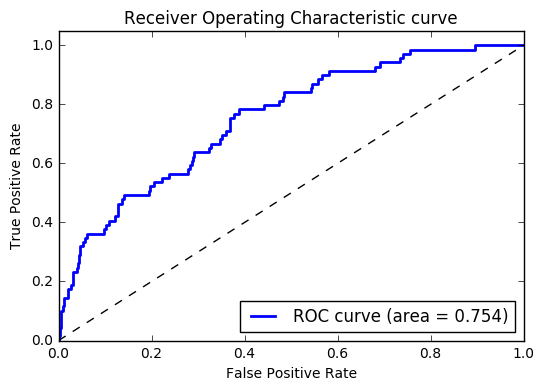

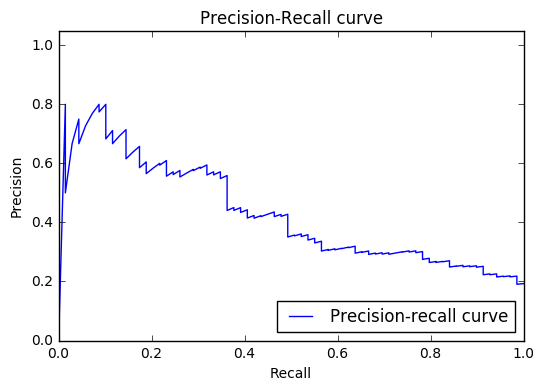

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.949301983835
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.949
('The confusion matrix on the testing set:          \n',       0   1
0  1292  69
1     0   0)
*********** AUC for ROC = 0.756


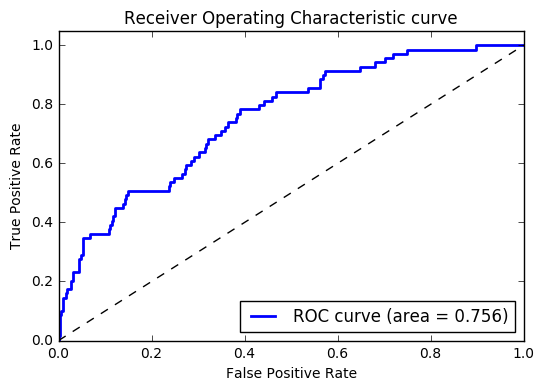

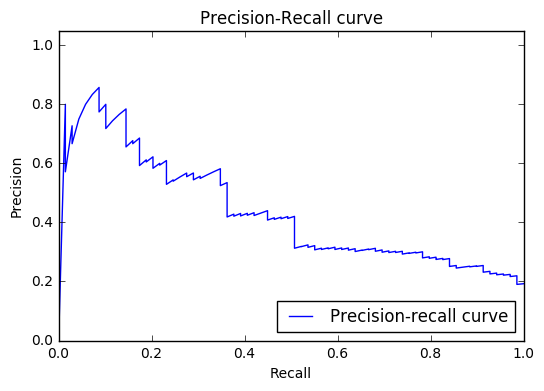

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.949301983835
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.949
('The confusion matrix on the testing set:          \n',       0   1
0  1292  69
1     0   0)
*********** AUC for ROC = 0.761


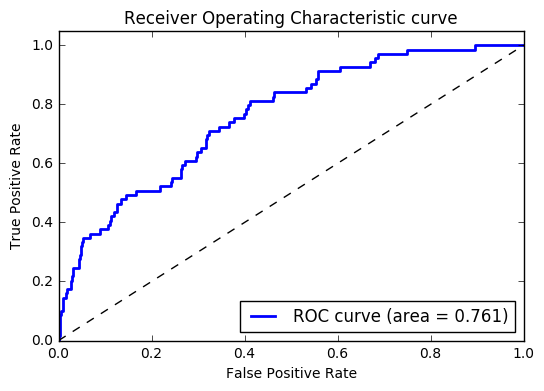

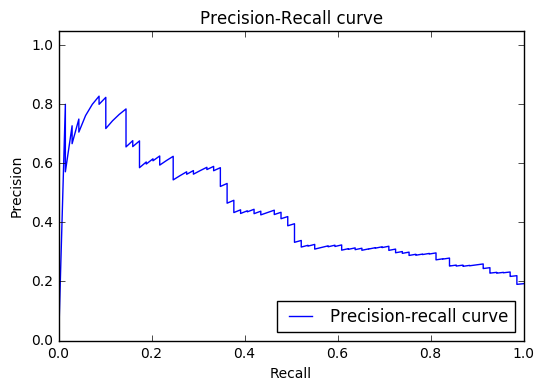

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.949301983835
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.949
('The confusion matrix on the testing set:          \n',       0   1
0  1292  69
1     0   0)
*********** AUC for ROC = 0.754


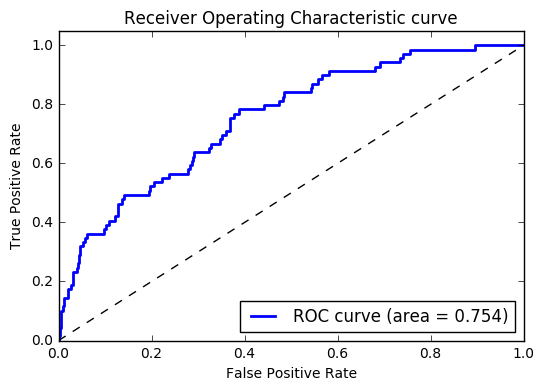

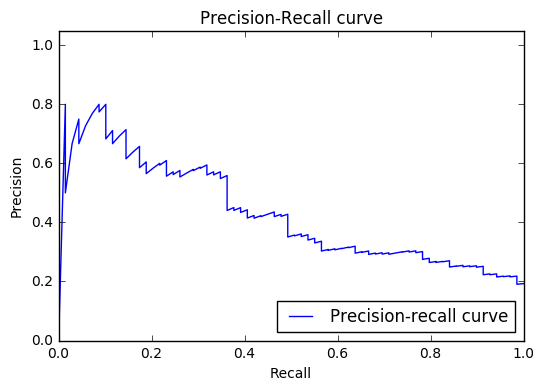

In [ ]:
#run 3
RANDOM_STATE = 21


X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

Perceptron50
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=50, n_jobs=1, penalty=None,
      random_state=71, shuffle=True, verbose=0, warm_start=False)
train time: 0.213s
test time:  0.007s
accuracy:   0.895
precision:  0.175
recall:     0.323
*** AUC for ROC = 0.707

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.96      0.92      0.94      1296
   Relevant       0.17      0.32      0.23        65

avg / total       0.93      0.89      0.91      1361

confusion matrix:
[[1197   99]
 [  44   21]]
()
Perceptron50l1
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=50, n_jobs=1, penalty='l1',
      random_state=71, shuffle=True, verbose=0, warm_start=False)
train time:

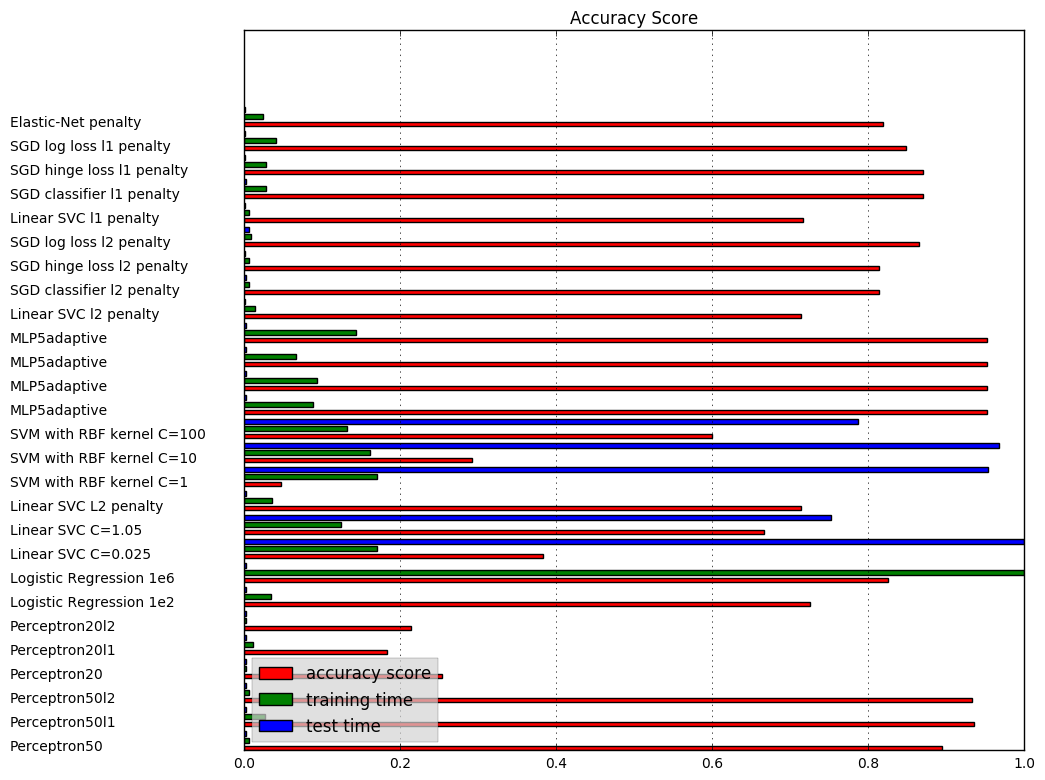

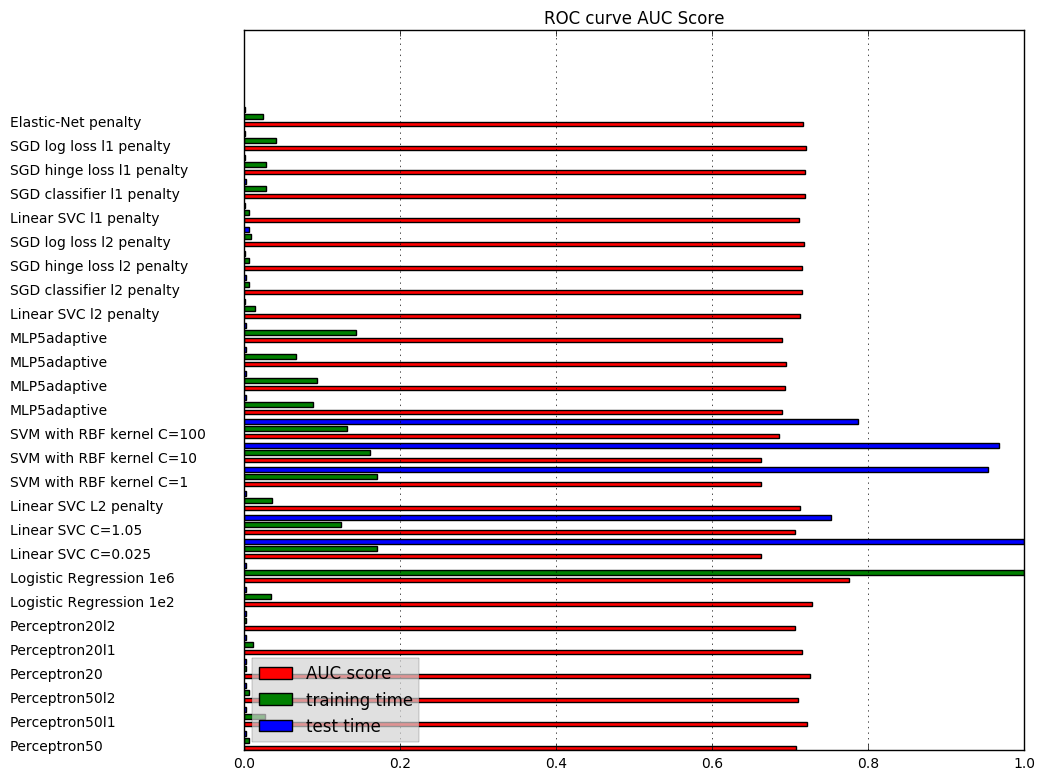

('\n', 'Perceptron50', '\ntest size is 40 %  ')
0.912564290963
precision = 0.437, recall = 0.200, F1 = 0.274, accuracy = 0.913
('The confusion matrix on the testing set:          \n',       0   1
0  1229  52
1    67  13)
*********** AUC for ROC = 0.702


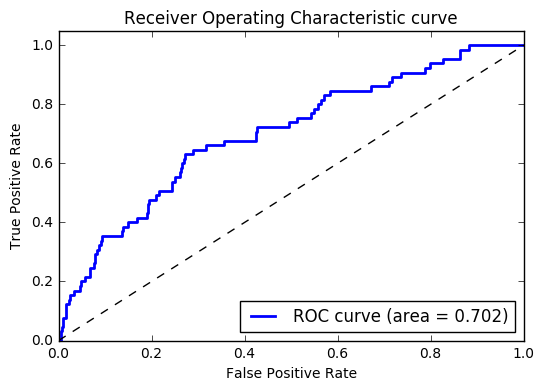

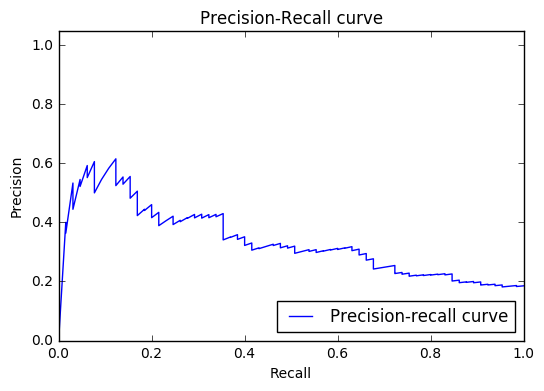

('\n', 'Perceptron50l1', '\ntest size is 40 %  ')
0.934606906686
precision = 0.522, recall = 0.138, F1 = 0.219, accuracy = 0.935
('The confusion matrix on the testing set:          \n',       0   1
0  1263  56
1    33   9)
*********** AUC for ROC = 0.716


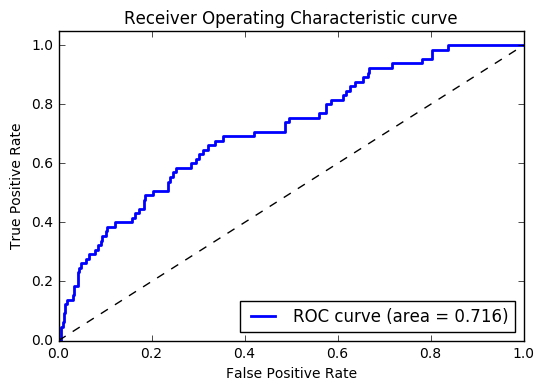

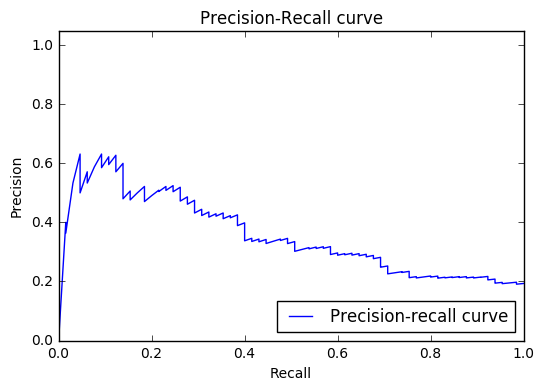

('\n', 'Perceptron50l2', '\ntest size is 40 %  ')
0.931667891256
precision = 0.559, recall = 0.200, F1 = 0.295, accuracy = 0.932
('The confusion matrix on the testing set:          \n',       0   1
0  1255  52
1    41  13)
*********** AUC for ROC = 0.683


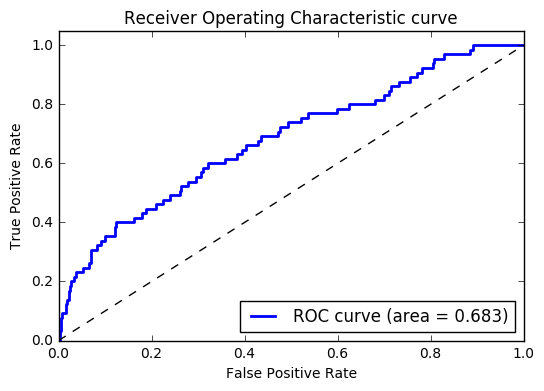

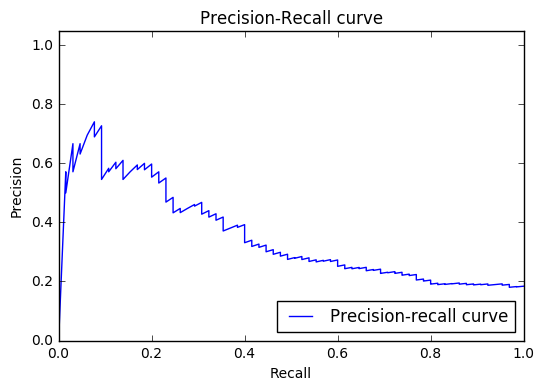

('\n', 'Perceptron20', '\ntest size is 40 %  ')
0.0653930933137
precision = 0.170, recall = 1.000, F1 = 0.290, accuracy = 0.065
('The confusion matrix on the testing set:          \n',       0   1
0    24   0
1  1272  65)
*********** AUC for ROC = 0.706


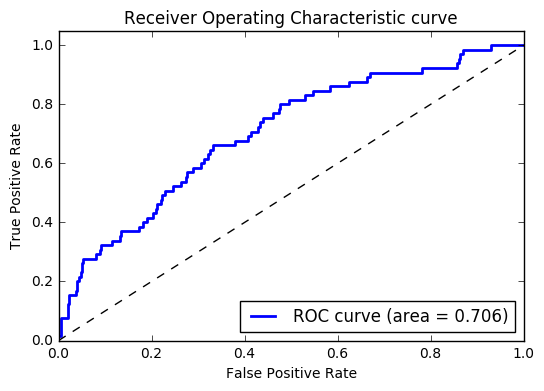

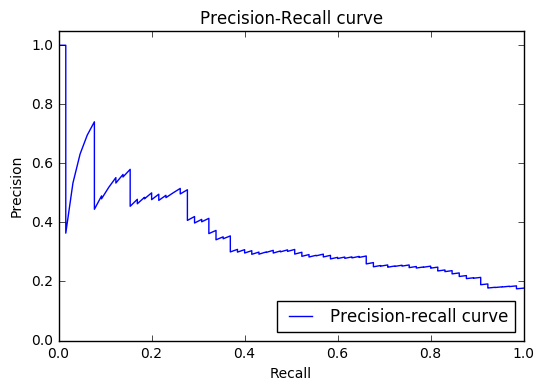

('\n', 'Perceptron20l1', '\ntest size is 40 %  ')
0.0573108008817
precision = 0.169, recall = 1.000, F1 = 0.288, accuracy = 0.057
('The confusion matrix on the testing set:          \n',       0   1
0    13   0
1  1283  65)
*********** AUC for ROC = 0.714


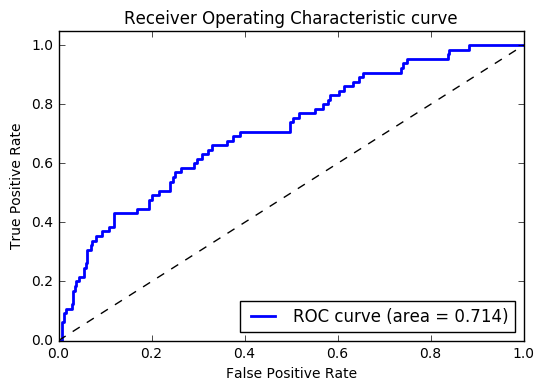

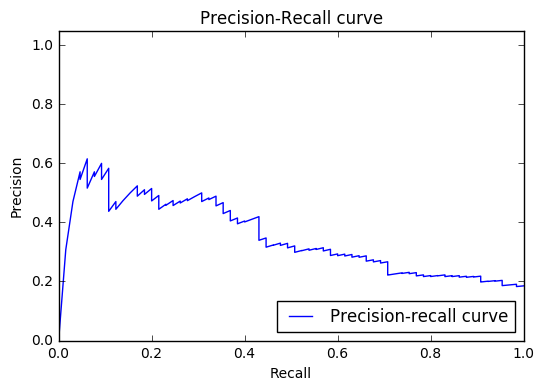

('\n', 'Perceptron20l2', '\ntest size is 40 %  ')
0.0506980161646
precision = 0.168, recall = 1.000, F1 = 0.287, accuracy = 0.051
('The confusion matrix on the testing set:          \n',       0   1
0     4   0
1  1292  65)
*********** AUC for ROC = 0.701


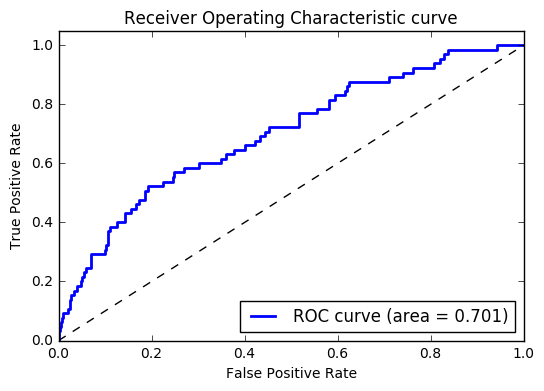

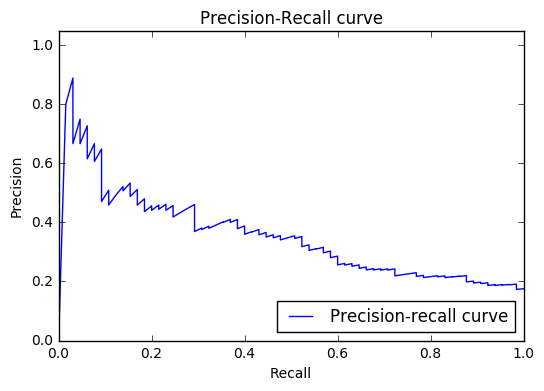

('\n', 'Logistic Regression 1e2', '\ntest size is 40 %  ')
0.73695811903
precision = 0.299, recall = 0.538, F1 = 0.385, accuracy = 0.737
('The confusion matrix on the testing set:          \n',      0   1
0  968  30
1  328  35)
*********** AUC for ROC = 0.720


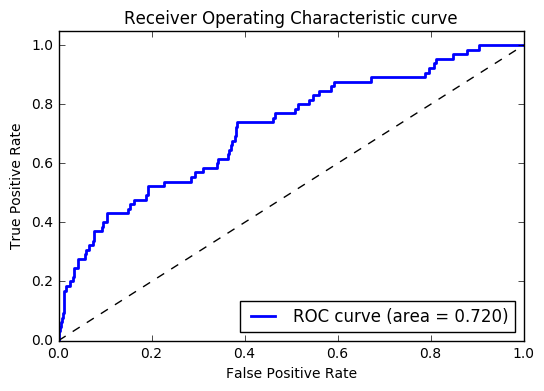

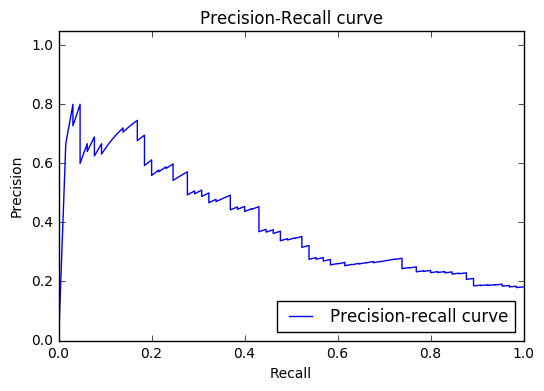

('\n', 'Logistic Regression 1e6', '\ntest size is 40 %  ')
0.822924320353
precision = 0.387, recall = 0.508, F1 = 0.439, accuracy = 0.823
('The confusion matrix on the testing set:          \n',       0   1
0  1087  32
1   209  33)
*********** AUC for ROC = 0.771


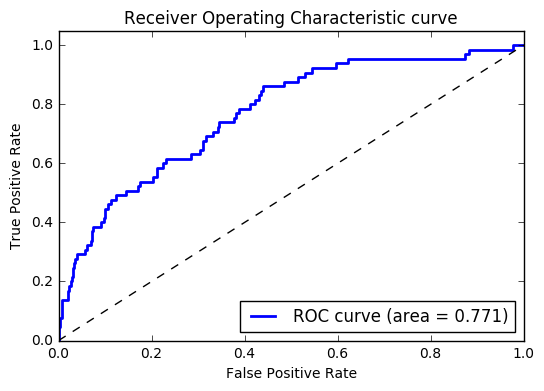

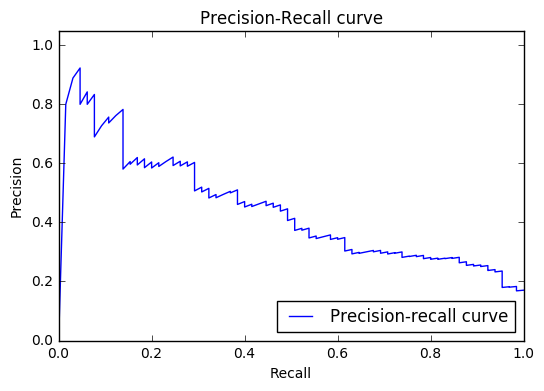

('\n', 'Linear SVC C=0.025', '\ntest size is 40 %  ')
0.500367376929
precision = 0.207, recall = 0.662, F1 = 0.316, accuracy = 0.500
('The confusion matrix on the testing set:          \n',      0   1
0  638  22
1  658  43)
*********** AUC for ROC = 0.655


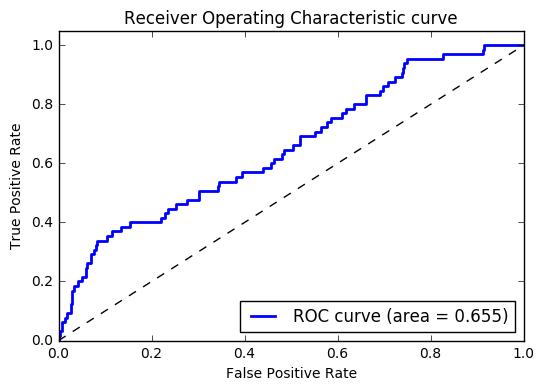

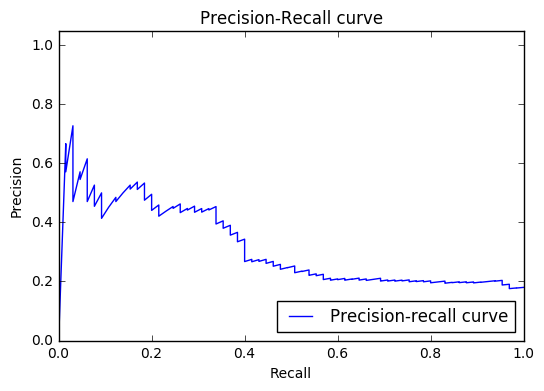

('\n', 'Linear SVC C=1.05', '\ntest size is 40 %  ')
0.705363703159
precision = 0.284, recall = 0.569, F1 = 0.379, accuracy = 0.705
('The confusion matrix on the testing set:          \n',      0   1
0  923  28
1  373  37)
*********** AUC for ROC = 0.696


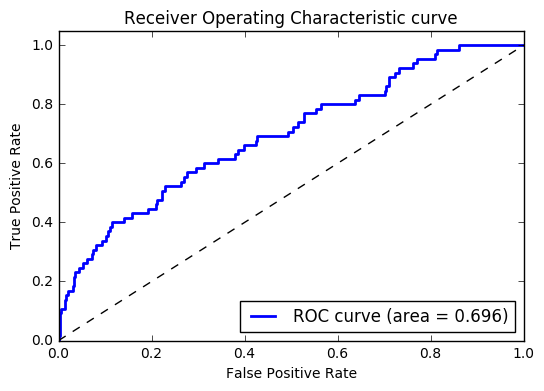

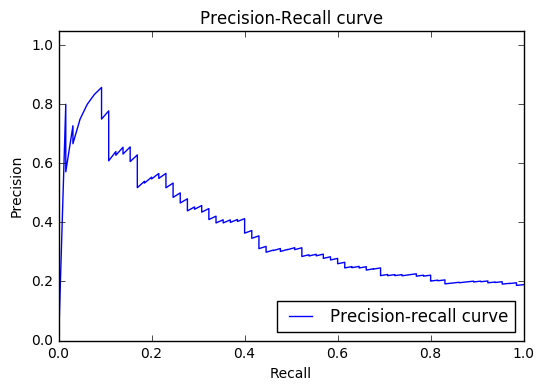

('\n', 'Linear SVC L2 penalty', '\ntest size is 40 %  ')
0.714180749449
precision = 0.286, recall = 0.554, F1 = 0.377, accuracy = 0.714
('The confusion matrix on the testing set:          \n',      0   1
0  936  29
1  360  36)
*********** AUC for ROC = 0.713


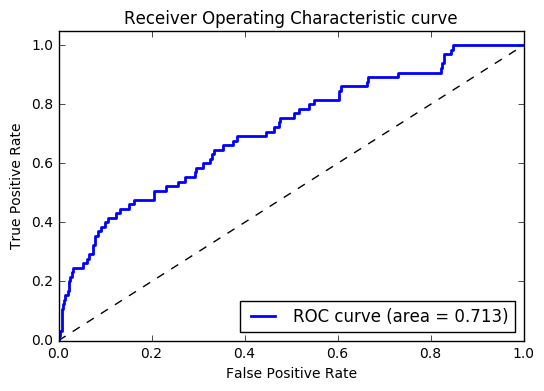

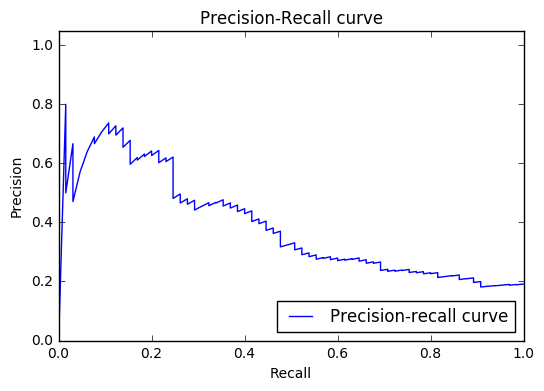

('\n', 'SVM with RBF kernel C=1', '\ntest size is 40 %  ')
0.952240999265
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.952
('The confusion matrix on the testing set:          \n',       0   1
0  1296  65
1     0   0)
*********** AUC for ROC = 0.653


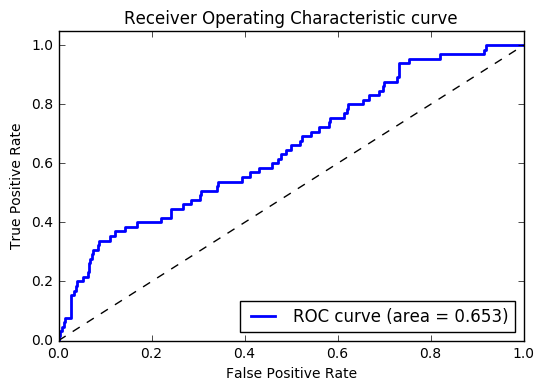

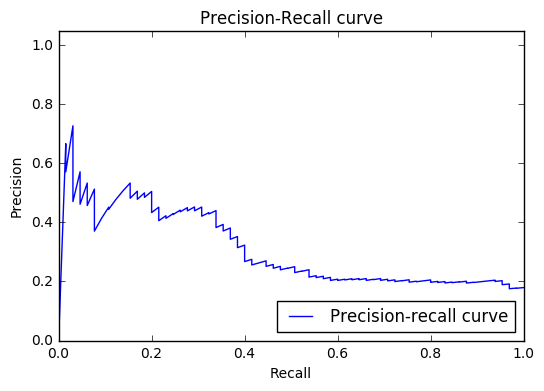

('\n', 'SVM with RBF kernel C=10', '\ntest size is 40 %  ')
0.475385745775
precision = 0.206, recall = 0.692, F1 = 0.317, accuracy = 0.475
('The confusion matrix on the testing set:          \n',      0   1
0  602  20
1  694  45)
*********** AUC for ROC = 0.653


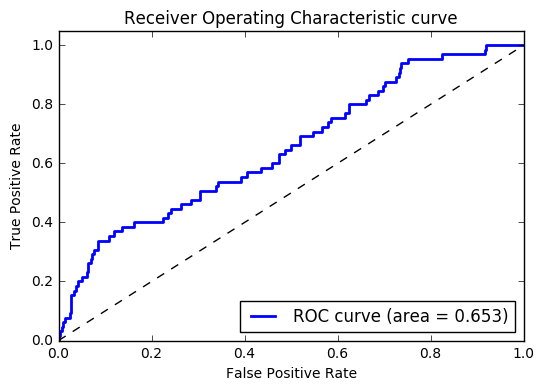

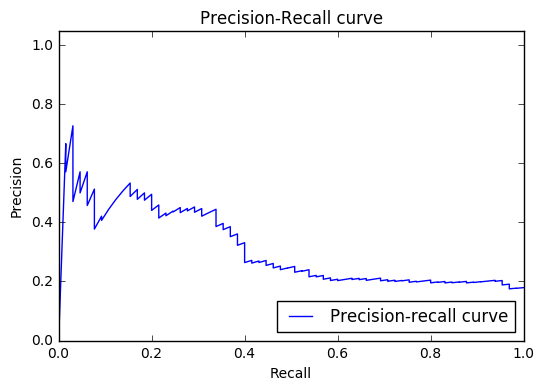

('\n', 'SVM with RBF kernel C=100', '\ntest size is 40 %  ')
0.64437913299
precision = 0.250, recall = 0.585, F1 = 0.350, accuracy = 0.644
('The confusion matrix on the testing set:          \n',      0   1
0  839  27
1  457  38)
*********** AUC for ROC = 0.683


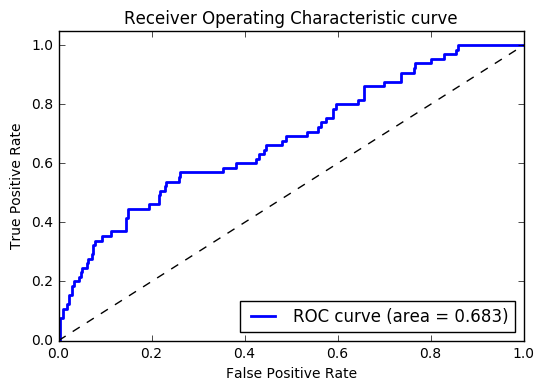

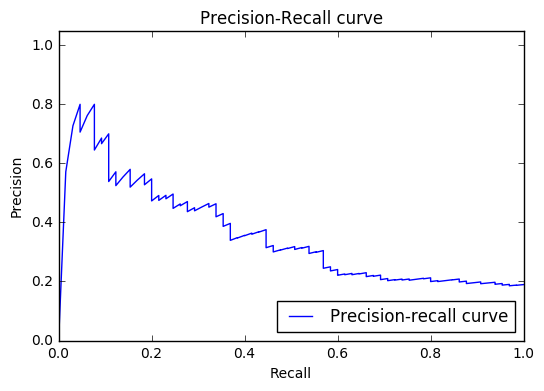

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.952240999265
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.952
('The confusion matrix on the testing set:          \n',       0   1
0  1296  65
1     0   0)
*********** AUC for ROC = 0.690


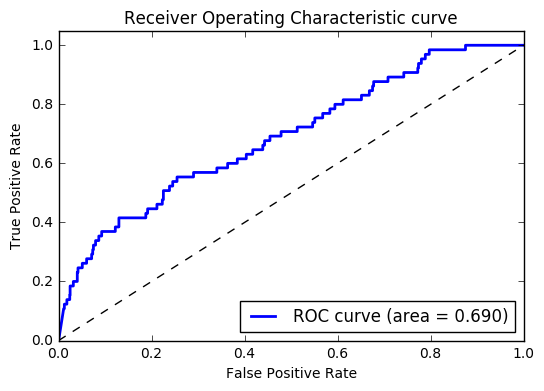

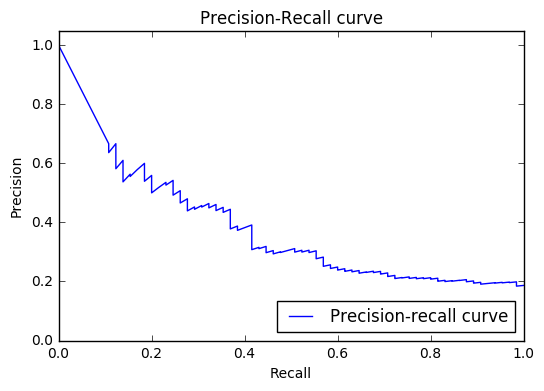

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.952240999265
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.952
('The confusion matrix on the testing set:          \n',       0   1
0  1296  65
1     0   0)
*********** AUC for ROC = 0.694


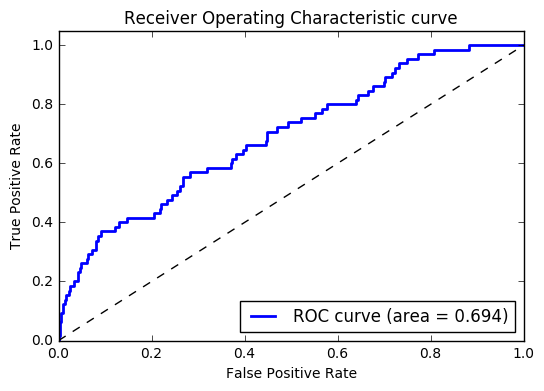

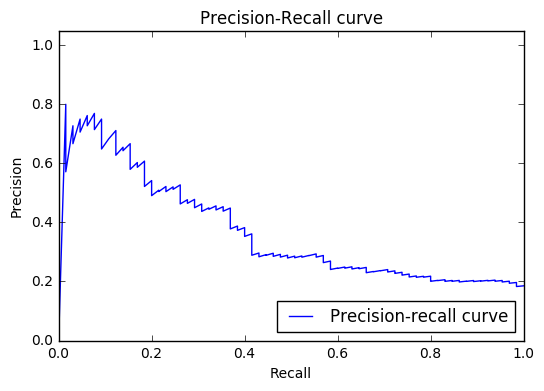

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.952240999265
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.952
('The confusion matrix on the testing set:          \n',       0   1
0  1296  65
1     0   0)
*********** AUC for ROC = 0.695


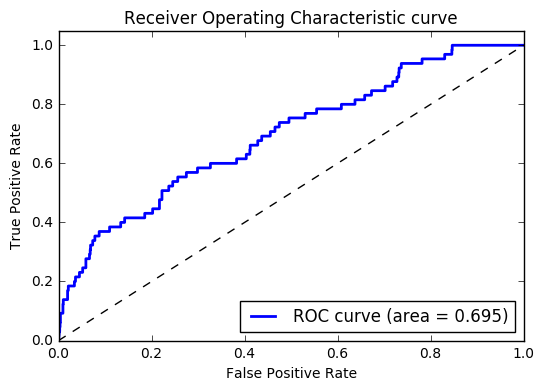

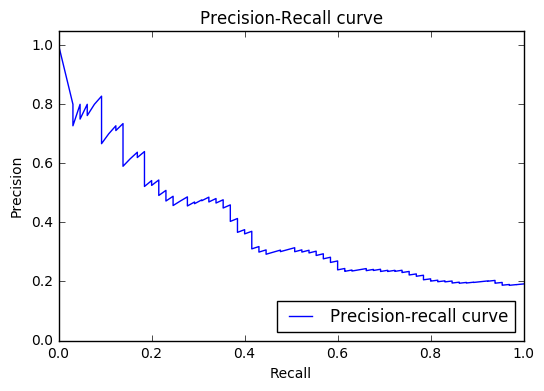

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.952240999265
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.952
('The confusion matrix on the testing set:          \n',       0   1
0  1296  65
1     0   0)
*********** AUC for ROC = 0.690


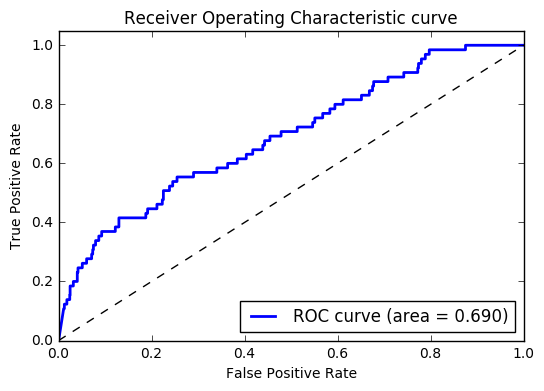

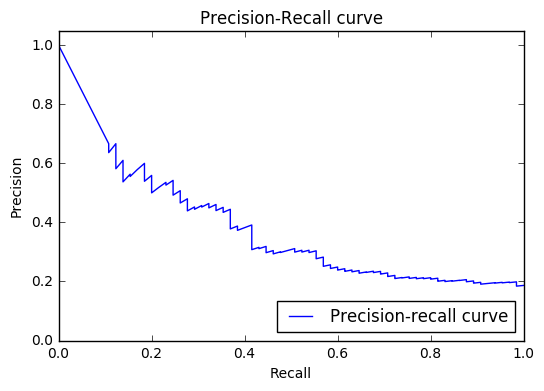

In [ ]:
#run 4
RANDOM_STATE =71


X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)

Perceptron50
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=50, n_jobs=1, penalty=None,
      random_state=35, shuffle=True, verbose=0, warm_start=False)
train time: 0.219s
test time:  0.007s
accuracy:   0.054
precision:  0.054
recall:     1.000
*** AUC for ROC = 0.711

classification report:
             precision    recall  f1-score   support

 Irrelevant       0.00      0.00      0.00      1288
   Relevant       0.05      1.00      0.10        73

avg / total       0.00      0.05      0.01      1361

confusion matrix:
[[   0 1288]
 [   0   73]]
()
Perceptron50l1
________________________________________________________________________________
Training: 
Perceptron(alpha=0.0001, class_weight='balanced', eta0=1.0,
      fit_intercept=True, n_iter=50, n_jobs=1, penalty='l1',
      random_state=35, shuffle=True, verbose=0, warm_start=False)
train time:

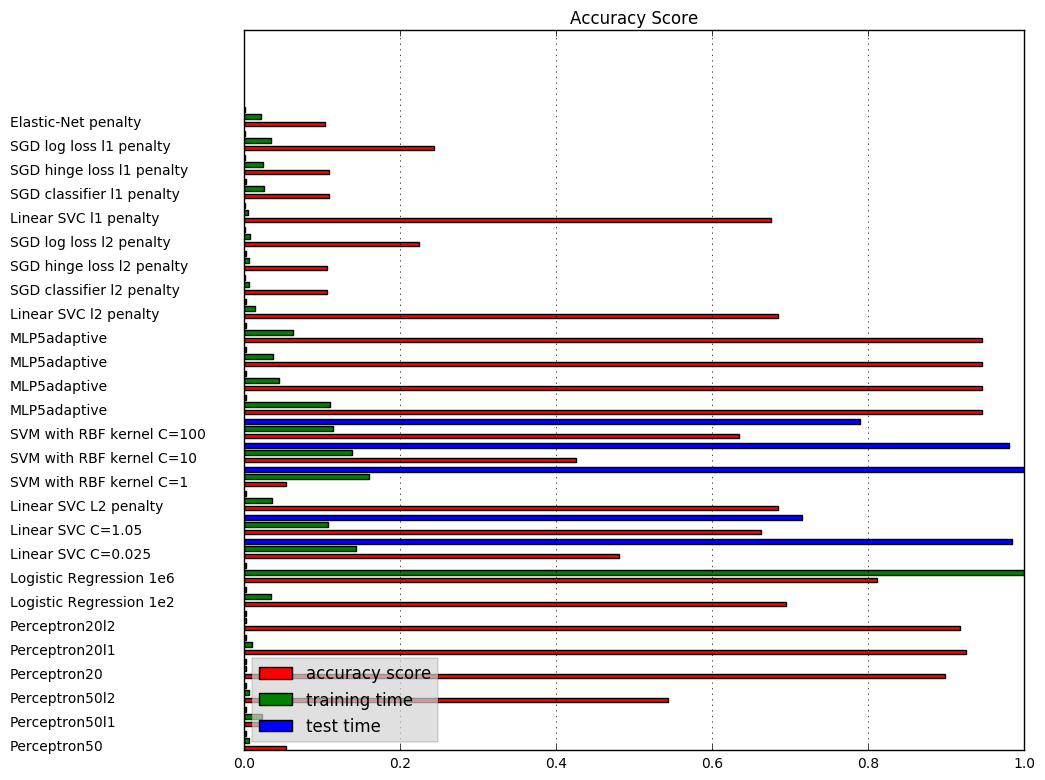

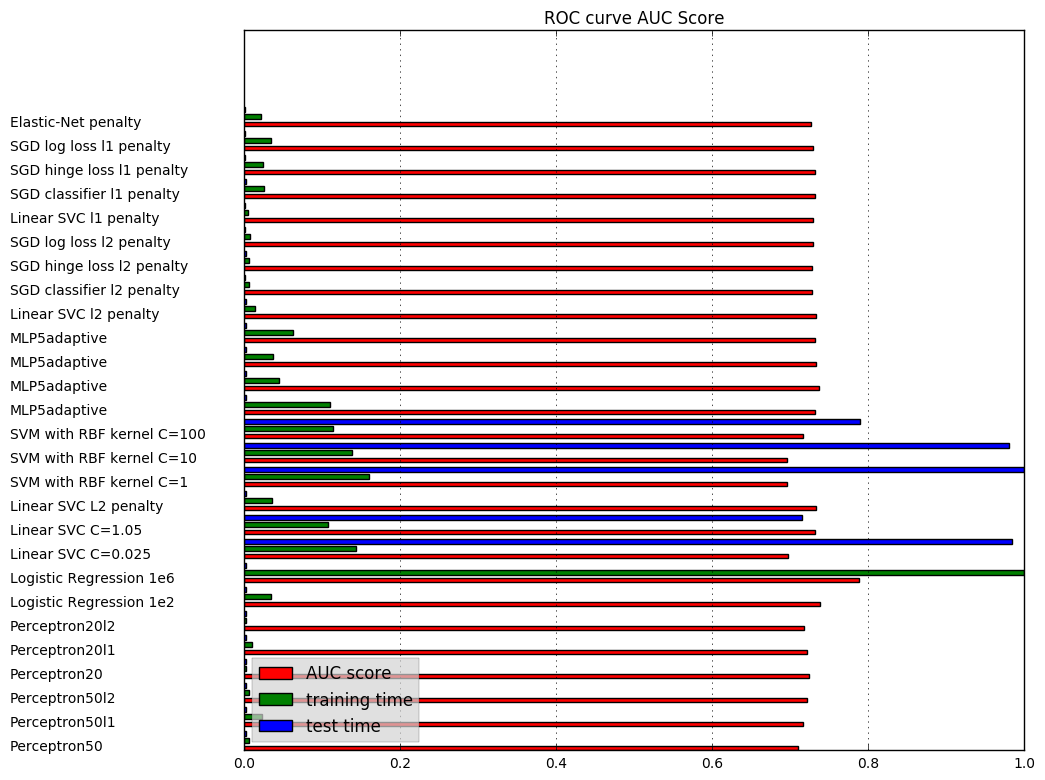

('\n', 'Perceptron50', '\ntest size is 40 %  ')
0.255694342395
precision = 0.217, recall = 0.959, F1 = 0.354, accuracy = 0.256
('The confusion matrix on the testing set:          \n',       0   1
0   278   3
1  1010  70)
*********** AUC for ROC = 0.721


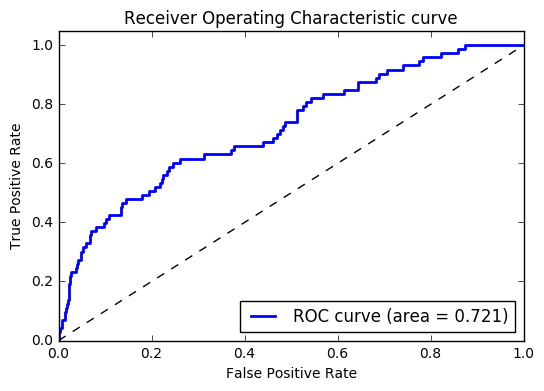

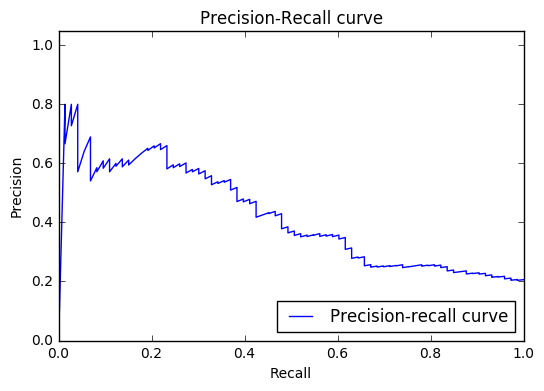

('\n', 'Perceptron50l1', '\ntest size is 40 %  ')
0.282880235121
precision = 0.226, recall = 0.973, F1 = 0.366, accuracy = 0.283
('The confusion matrix on the testing set:          \n',      0   1
0  314   2
1  974  71)
*********** AUC for ROC = 0.727


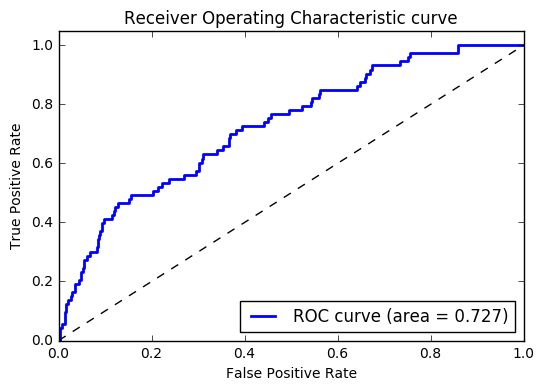

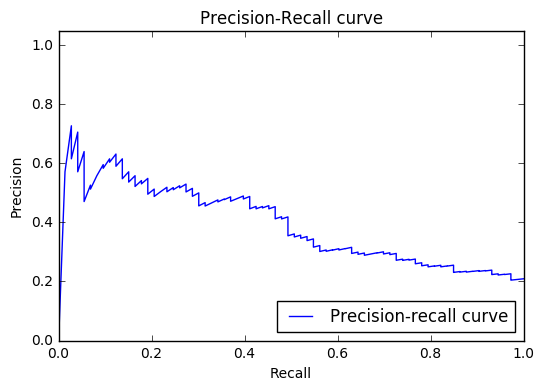

('\n', 'Perceptron50l2', '\ntest size is 40 %  ')
0.280675973549
precision = 0.227, recall = 0.986, F1 = 0.370, accuracy = 0.281
('The confusion matrix on the testing set:          \n',      0   1
0  310   1
1  978  72)
*********** AUC for ROC = 0.701


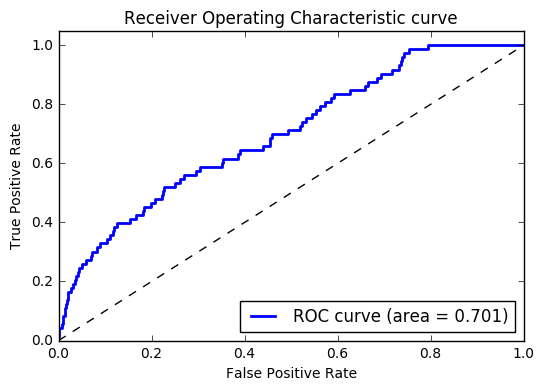

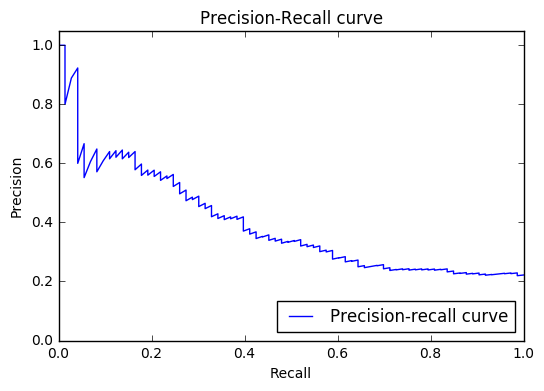

('\n', 'Perceptron20', '\ntest size is 40 %  ')
0.903012490816
precision = 0.503, recall = 0.274, F1 = 0.355, accuracy = 0.903
('The confusion matrix on the testing set:          \n',       0   1
0  1209  53
1    79  20)
*********** AUC for ROC = 0.722


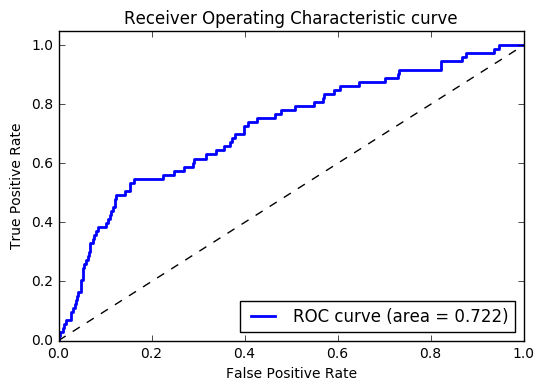

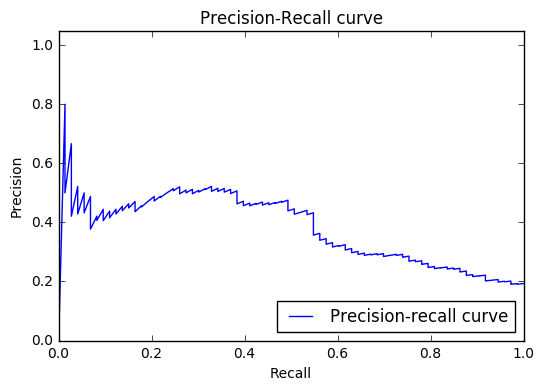

('\n', 'Perceptron20l1', '\ntest size is 40 %  ')
0.916972814107
precision = 0.509, recall = 0.192, F1 = 0.279, accuracy = 0.917
('The confusion matrix on the testing set:          \n',       0   1
0  1234  59
1    54  14)
*********** AUC for ROC = 0.714


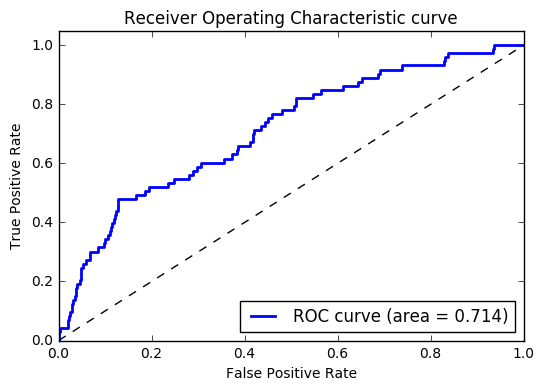

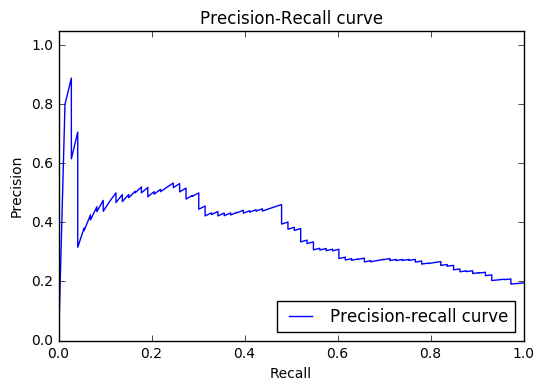

('\n', 'Perceptron20l2', '\ntest size is 40 %  ')
0.914768552535
precision = 0.430, recall = 0.137, F1 = 0.208, accuracy = 0.915
('The confusion matrix on the testing set:          \n',       0   1
0  1235  63
1    53  10)
*********** AUC for ROC = 0.708


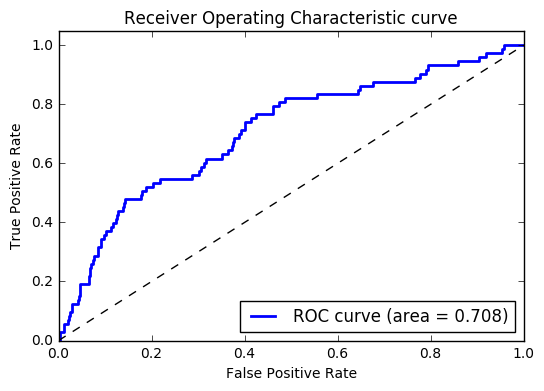

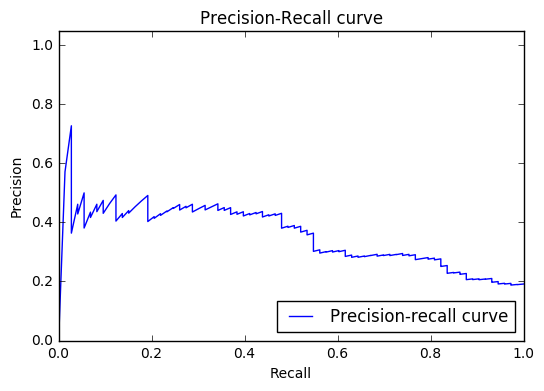

('\n', 'Logistic Regression 1e2', '\ntest size is 40 %  ')
0.703159441587
precision = 0.328, recall = 0.630, F1 = 0.431, accuracy = 0.703
('The confusion matrix on the testing set:          \n',      0   1
0  911  27
1  377  46)
*********** AUC for ROC = 0.738


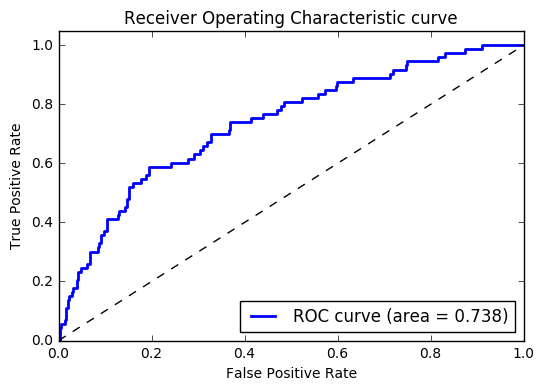

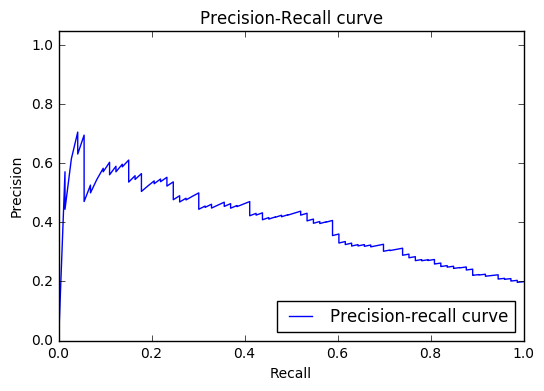

('\n', 'Logistic Regression 1e6', '\ntest size is 40 %  ')
0.811168258633
precision = 0.444, recall = 0.630, F1 = 0.521, accuracy = 0.811
('The confusion matrix on the testing set:          \n',       0   1
0  1058  27
1   230  46)
*********** AUC for ROC = 0.781


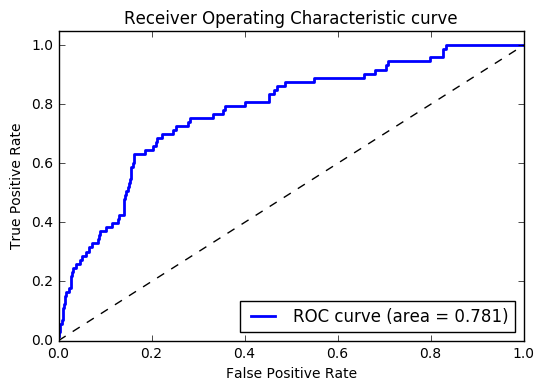

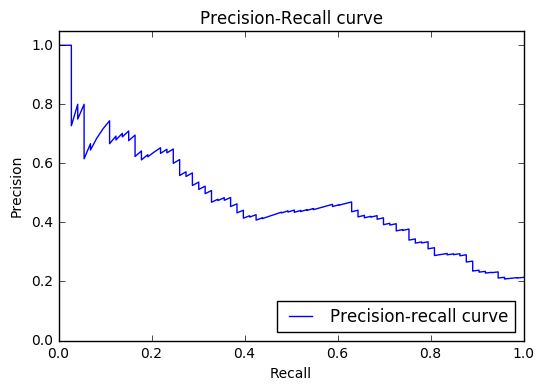

('\n', 'Linear SVC C=0.025', '\ntest size is 40 %  ')
0.479059515062
precision = 0.238, recall = 0.740, F1 = 0.361, accuracy = 0.479
('The confusion matrix on the testing set:          \n',      0   1
0  598  19
1  690  54)
*********** AUC for ROC = 0.694


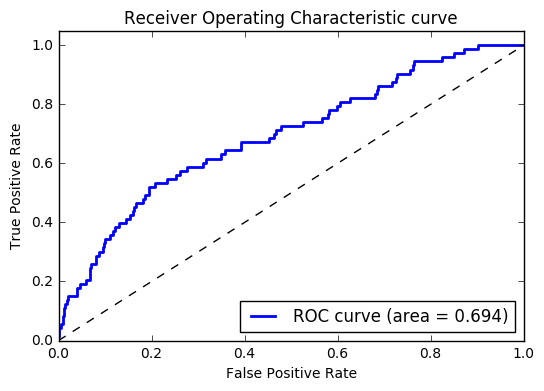

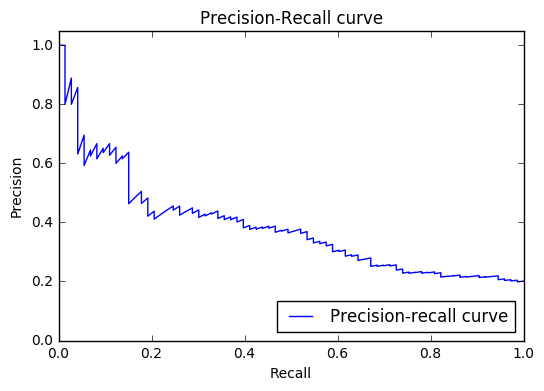

('\n', 'Linear SVC C=1.05', '\ntest size is 40 %  ')
0.660543717855
precision = 0.309, recall = 0.671, F1 = 0.423, accuracy = 0.661
('The confusion matrix on the testing set:          \n',      0   1
0  850  24
1  438  49)
*********** AUC for ROC = 0.727


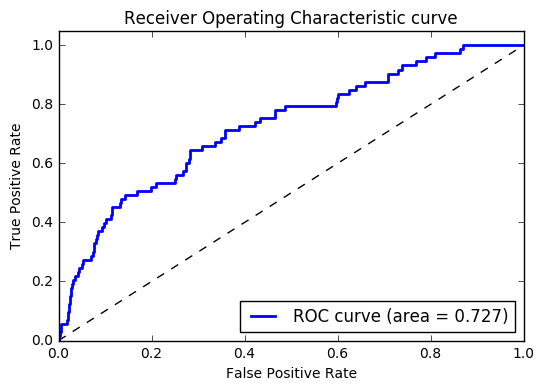

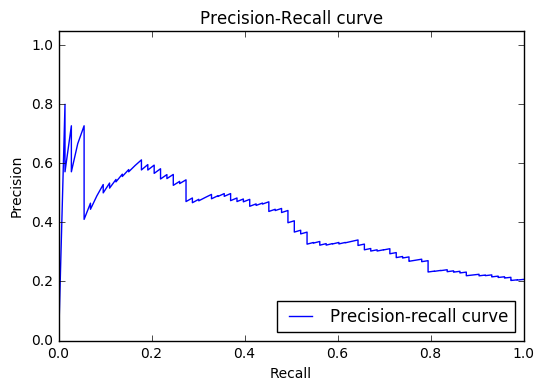

('\n', 'Linear SVC L2 penalty', '\ntest size is 40 %  ')
0.684055841293
precision = 0.309, recall = 0.616, F1 = 0.412, accuracy = 0.684
('The confusion matrix on the testing set:          \n',      0   1
0  886  28
1  402  45)
*********** AUC for ROC = 0.734


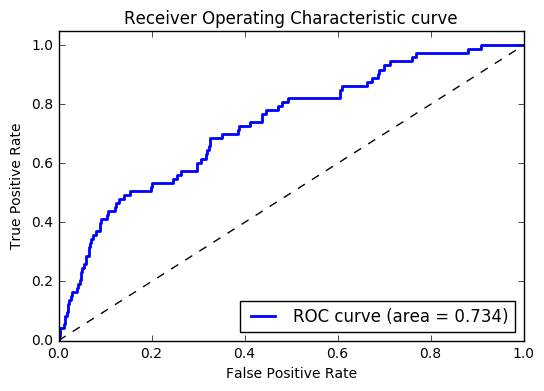

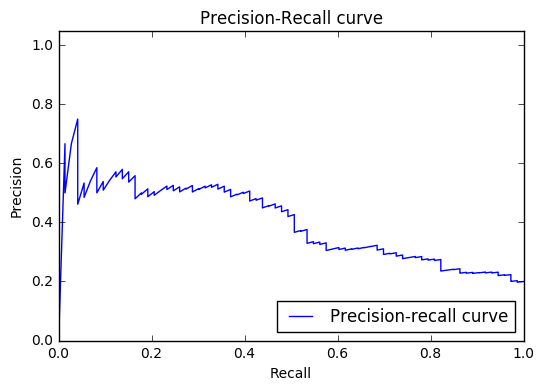

('\n', 'SVM with RBF kernel C=1', '\ntest size is 40 %  ')
0.0536370315944
precision = 0.185, recall = 1.000, F1 = 0.312, accuracy = 0.054
('The confusion matrix on the testing set:          \n',       0   1
0     0   0
1  1288  73)
*********** AUC for ROC = 0.693


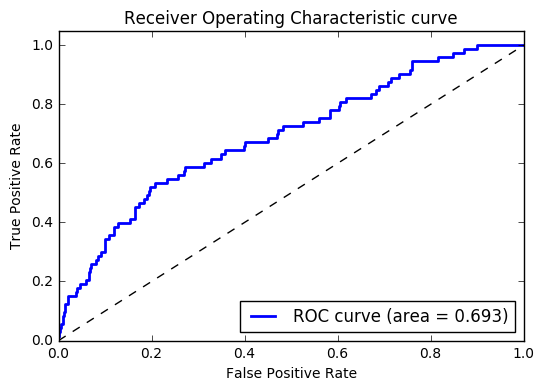

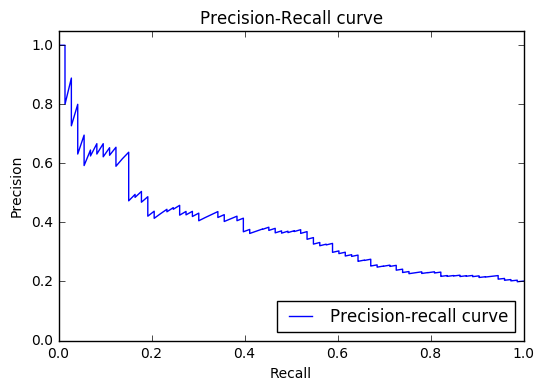

('\n', 'SVM with RBF kernel C=10', '\ntest size is 40 %  ')
0.390889052168
precision = 0.227, recall = 0.822, F1 = 0.356, accuracy = 0.391
('The confusion matrix on the testing set:          \n',      0   1
0  472  13
1  816  60)
*********** AUC for ROC = 0.693


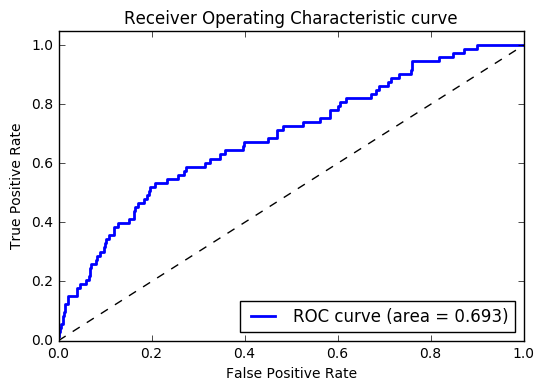

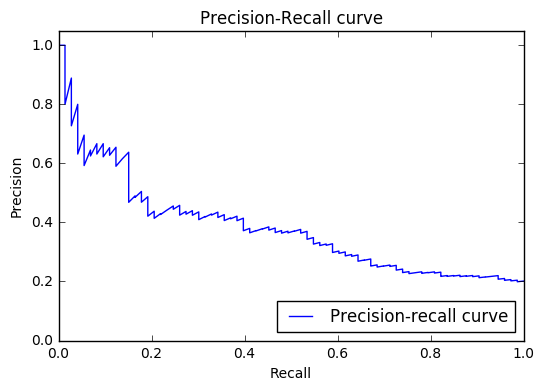

('\n', 'SVM with RBF kernel C=100', '\ntest size is 40 %  ')
0.628214548126
precision = 0.300, recall = 0.712, F1 = 0.422, accuracy = 0.628
('The confusion matrix on the testing set:          \n',      0   1
0  803  21
1  485  52)
*********** AUC for ROC = 0.712


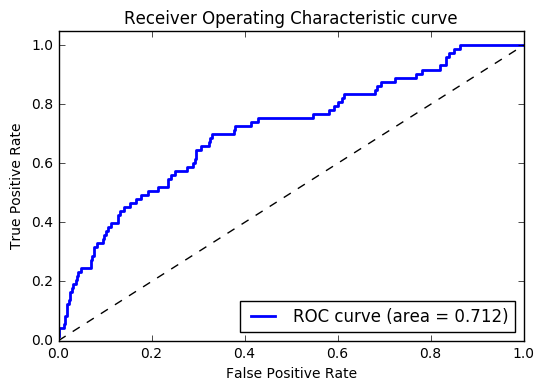

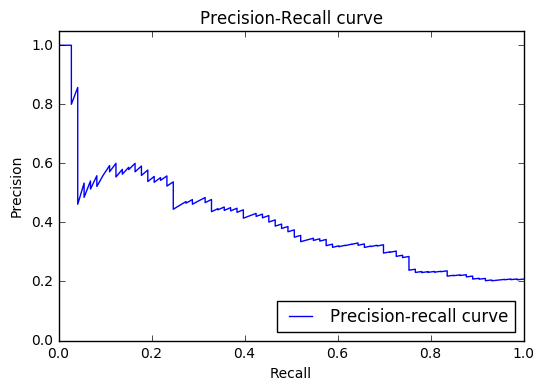

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.946362968406
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.946
('The confusion matrix on the testing set:          \n',       0   1
0  1288  73
1     0   0)
*********** AUC for ROC = 0.732


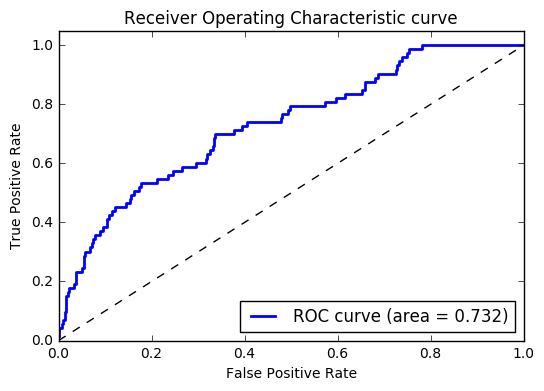

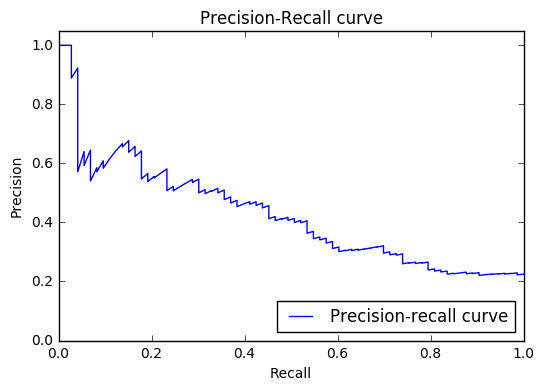

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.946362968406
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.946
('The confusion matrix on the testing set:          \n',       0   1
0  1288  73
1     0   0)
*********** AUC for ROC = 0.737


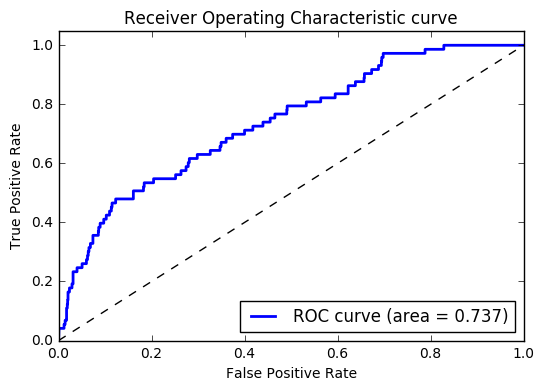

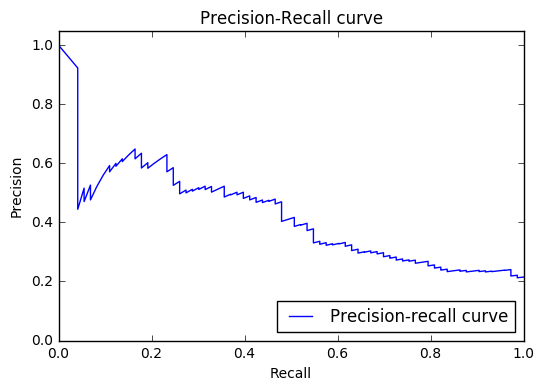

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.946362968406
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.946
('The confusion matrix on the testing set:          \n',       0   1
0  1288  73
1     0   0)
*********** AUC for ROC = 0.733


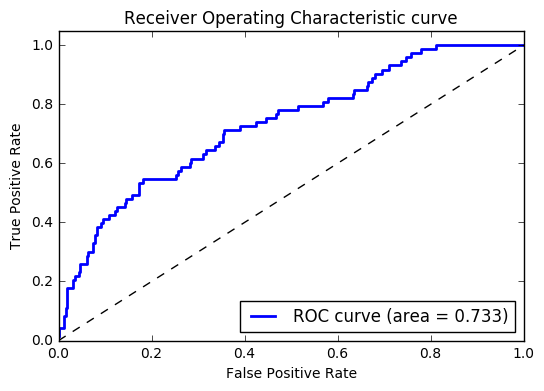

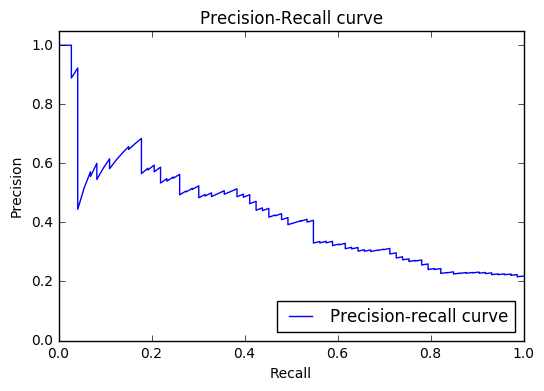

('\n', 'MLP5adaptive', '\ntest size is 40 %  ')
0.946362968406
precision = 0.000, recall = 0.000, F1 = 0.000, accuracy = 0.946
('The confusion matrix on the testing set:          \n',       0   1
0  1288  73
1     0   0)
*********** AUC for ROC = 0.732


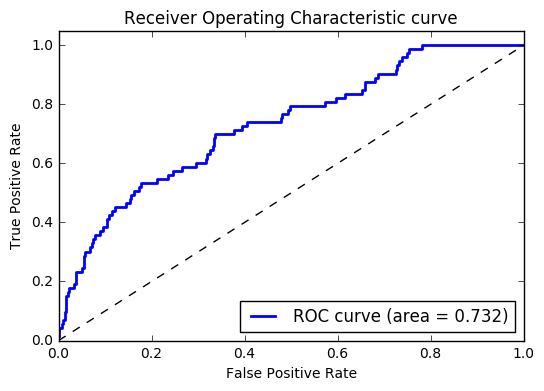

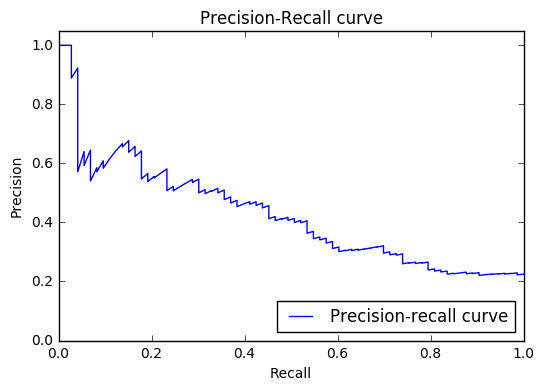

In [ ]:
#run 5
RANDOM_STATE = 35


X_train, X_test, y_train, y_test = train_test_split(averageWordVecs, inhibitor.Label, test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

# run the comparision of the battery of classifiers and plot out the results
comparison_plots(create_results())
# run the classifications for the battery of classifiers
run_class(averageWordVecs, inhibitor.Label, TEST_SIZE)